# Commitment Analysis Across 1P2G and 2P3G Experiments

This notebook analyzes commitment patterns across different experimental conditions:

**1P2G Commitment**: Whether human's first intended goal (`player1FirstDetectedGoal`) matches their final reached goal (`player1FinalReachedGoal`)

**2P3G Commitment**: Whether the first detected shared goal (`firstDetectedSharedGoal`) matches the final reached goal

Analysis compares commitment across different RL agent types (individual vs joint).


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

# Set publication standards
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.titlesize': 16,
    'font.family': 'Arial'
})

# Set color palette - different colors for different game types
colors = {'human-human': 'lightblue', 'human-gpt': 'lightcoral', 'mixed': 'lightgreen'}
bar_colors = ['lightblue', 'lightcoral', 'lightgreen']  # for human-human, human-gpt, and mixed
sns.set_palette([colors['human-human'], colors['human-gpt'], colors['mixed']])

In [57]:
# Load and prepare data
data_dir = Path.cwd().parent / 'data'
excel_files = [f for f in data_dir.glob('*.xlsx') if not f.name.startswith('~$')]

def load_and_process_file(file_path):
    """Load Excel file and add metadata"""
    try:
        df = pd.read_excel(file_path)
        participant_id = file_path.name.split('_')[2]
        # Attach identifiers we can merge/group by later
        df = df.assign(participantID=participant_id, file_id=file_path.name)
        return df
    except Exception as e:
        print(f"Error loading {file_path.name}: {e}")
        return None

# Load all files
all_data = []
for file_path in excel_files:
    df_part = load_and_process_file(file_path)
    if df_part is not None:
        all_data.append(df_part)

# Combine all data
df = pd.concat(all_data, ignore_index=True)

# Load game classification from the precomputed classification file
try:
    class_map = pd.read_csv(data_dir / 'game_classification_results.csv')[['file_id','game_class']]

    # Merge with the main dataframe
    if 'file_id' in df.columns:
        df = df.merge(class_map, on='file_id', how='left', suffixes=('', '_from_class_map'))
        print("Merged game classification using file_id")
    else:
        # If file_id is absent, attempt to reconstruct from roomId when available
        if 'room_id' in df.columns or 'roomId' in df.columns:
            room_col = 'room_id' if 'room_id' in df.columns else 'roomId'
            class_map_room = pd.read_csv(data_dir / 'game_classification_results.csv')[['room_id','game_class']].drop_duplicates()
            df = df.merge(class_map_room, left_on=room_col, right_on='room_id', how='left')
            print("Merged game classification using room_id")
        else:
            print("Warning: No file_id or room_id available for merging game classification")

    # Map the game_class values to meaningful categories for analysis
    # The classification file contains: human-human, human-gpt, mixed
    # For commitment analysis, we'll treat these as different partner types
    if 'game_class' in df.columns:
        # Keep the original game_class values as they represent meaningful categories
        # human-human: both players are human
        # human-gpt: human playing with GPT agent
        # mixed: mixed conditions within the same session
        pass

except Exception as e:
    print('Failed to load game classification:', e)
    # Create a default game_class column
    df['game_class'] = 'unknown'

print(f"Loaded {len(df)} trials from {len(excel_files)} participants")
print(f"Experiment types: {df['experimentType'].unique()}")
if 'game_class' in df.columns:
    print(f"Game types: {pd.Series(df['game_class']).dropna().unique()}")
    print(f"Game type distribution: {df['game_class'].value_counts().to_dict()}")
else:
    print('Game types: N/A')


Merged game classification using file_id
Loaded 1005 trials from 29 participants
Experiment types: ['1P1G' '1P2G' '2P2G' '2P3G']
Game types: ['human-human' 'human-gpt' 'mixed']
Game type distribution: {'human-human': 560, 'human-gpt': 235, 'mixed': 210}


In [58]:
# Examine data structure for commitment analysis
print("=== Data Structure for Commitment Analysis ===")
print("\n1P2G relevant columns:")
print("- player1FirstDetectedGoal:", df[df['experimentType']=='1P2G']['player1FirstDetectedGoal'].dtype)
print("- player1FinalReachedGoal:", df[df['experimentType']=='1P2G']['player1FinalReachedGoal'].dtype)

print("\n2P3G relevant columns:")
print("- firstDetectedSharedGoal:", df[df['experimentType']=='2P3G']['firstDetectedSharedGoal'].dtype if '2P3G' in df['experimentType'].values else "No 2P3G data found")

# Check what experiment types we actually have
print("\nActual experiment types in data:")
print(df['experimentType'].value_counts())

# Check sample data
print("\nSample 1P2G data:")
sample_1p2g = df[df['experimentType']=='1P2G'].head()
for col in ['player1FirstDetectedGoal', 'player1FinalReachedGoal']:
    if col in sample_1p2g.columns:
        print(f"{col}: {sample_1p2g[col].tolist()[:5]}")

print("\nSample 2P2G data (checking for shared goal fields):")
sample_2p2g = df[df['experimentType']=='2P2G'].head()
for col in ['firstDetectedSharedGoal', 'player1FinalReachedGoal', 'player2FinalReachedGoal']:
    if col in sample_2p2g.columns:
        print(f"{col}: {sample_2p2g[col].tolist()[:5]}")


=== Data Structure for Commitment Analysis ===

1P2G relevant columns:
- player1FirstDetectedGoal: float64
- player1FinalReachedGoal: int64

2P3G relevant columns:
- firstDetectedSharedGoal: float64

Actual experiment types in data:
experimentType
1P2G    346
2P3G    344
2P2G    229
1P1G     86
Name: count, dtype: int64

Sample 1P2G data:
player1FirstDetectedGoal: [0.0, 1.0, 0.0, 1.0, 1.0]
player1FinalReachedGoal: [0, 1, 0, 1, 1]

Sample 2P2G data (checking for shared goal fields):
firstDetectedSharedGoal: [nan, nan, nan, nan, nan]
player1FinalReachedGoal: [1, 0, 1, 0, 0]
player2FinalReachedGoal: [1, 0, 1, 0, 0]


In [59]:
def calculate_commitment_1p2g(row):
    """Calculate commitment for 1P2G: first detected goal == final reached goal"""
    first_goal = row['player1FirstDetectedGoal']
    final_goal = row['player1FinalReachedGoal']

    # Handle missing or null values
    if pd.isna(first_goal) or pd.isna(final_goal):
        return np.nan

    # Convert to int if possible for comparison
    try:
        first_goal = int(first_goal)
        final_goal = int(final_goal)
        return 1 if first_goal == final_goal else 0
    except (ValueError, TypeError):
        return np.nan

def calculate_commitment_2p3g(row):
    """Calculate commitment for 2P3G: first detected shared goal == final reached goal"""
    shared_goal = row.get('firstDetectedSharedGoal')
    # For 2P3G, we need to determine what the final reached goal is
    # This might be when both players reach the same goal
    final_goal_p1 = row.get('player1FinalReachedGoal')
    final_goal_p2 = row.get('player2FinalReachedGoal')

    # Handle missing values
    if pd.isna(shared_goal):
        return np.nan

    # If both players reached the same goal, that's the final goal
    if not pd.isna(final_goal_p1) and not pd.isna(final_goal_p2):
        try:
            shared_goal = int(shared_goal)
            final_goal_p1 = int(final_goal_p1)
            final_goal_p2 = int(final_goal_p2)

            # Check if they reached the same goal
            if final_goal_p1 == final_goal_p2:
                final_goal = final_goal_p1
                return 1 if shared_goal == final_goal else 0
            else:
                return 0  # No commitment if they didn't reach the same goal
        except (ValueError, TypeError):
            return np.nan

    return np.nan

# Apply commitment calculations
df_1p2g = df[df['experimentType'] == '1P2G'].copy()
df_1p2g['commitment'] = df_1p2g.apply(calculate_commitment_1p2g, axis=1)
df_1p2g['experiment_category'] = '1P2G'

# Check if we have 2P3G data, otherwise use 2P2G as proxy
if '2P3G' in df['experimentType'].values:
    df_2p3g = df[df['experimentType'] == '2P3G'].copy()
    df_2p3g['commitment'] = df_2p3g.apply(calculate_commitment_2p3g, axis=1)
    df_2p3g['experiment_category'] = '2P3G'
else:
    print("No 2P3G data found, using 2P2G as collaborative condition")
    df_2p3g = df[df['experimentType'] == '2P2G'].copy()
    df_2p3g['commitment'] = df_2p3g.apply(calculate_commitment_2p3g, axis=1)
    df_2p3g['experiment_category'] = '2P2G (Collaborative)'

# Combine data
commitment_data = pd.concat([df_1p2g, df_2p3g], ignore_index=True)

print(f"Commitment analysis prepared for {len(commitment_data)} trials")
print(f"Valid commitment scores: {commitment_data['commitment'].notna().sum()}")
print("\nCommitment by experiment type:")
print(commitment_data.groupby('experiment_category')['commitment'].agg(['count', 'mean', 'std']).round(3))


Commitment analysis prepared for 690 trials
Valid commitment scores: 680

Commitment by experiment type:
                     count   mean    std
experiment_category                     
1P2G                   346  0.792  0.407
2P3G                   334  0.769  0.422


In [60]:
# Aggregate data at participant level first
print("=== Aggregating Data at Participant Level ===")
participant_commitment = commitment_data.groupby(['participantID', 'experiment_category', 'game_class'])['commitment'].agg([
    'count', 'mean'
]).reset_index()
participant_commitment.columns = ['participantID', 'experiment_category', 'game_class', 'n_trials', 'commitment_rate']

print(f"Participant-level data: {len(participant_commitment)} participants")
print(participant_commitment.groupby(['experiment_category', 'game_class']).agg({
    'participantID': 'count',
    'commitment_rate': ['mean', 'std', 'sem'],
    'n_trials': 'mean'
}).round(3))

# Analyze commitment by RL agent type using participant-level data
commitment_by_rl_participant = participant_commitment.groupby(['experiment_category', 'game_class'])['commitment_rate'].agg([
    'count', 'mean', 'std', 'sem'
]).round(3)

print("\n=== Commitment Analysis by RL Agent Type (Participant-Level) ===")
print(commitment_by_rl_participant)

# Statistical tests using participant-level data
print("\n=== Statistical Tests (Participant-Level) ===")

# Test within each experiment type
for exp_type in participant_commitment['experiment_category'].unique():
    exp_data = participant_commitment[participant_commitment['experiment_category'] == exp_type]

    individual_data = exp_data[exp_data['game_class'] == 'individual']['commitment_rate'].dropna()
    joint_data = exp_data[exp_data['game_class'] == 'joint']['commitment_rate'].dropna()

    if len(individual_data) > 0 and len(joint_data) > 0:
        # T-test
        t_stat, p_value = stats.ttest_ind(individual_data, joint_data)

        # Mann-Whitney U test (non-parametric)
        u_stat, u_p_value = stats.mannwhitneyu(individual_data, joint_data, alternative='two-sided')

        # Calculate effect size (Cohen's d)
        pooled_std = np.sqrt(((len(individual_data)-1)*individual_data.var() +
                             (len(joint_data)-1)*joint_data.var()) /
                            (len(individual_data) + len(joint_data) - 2))
        cohens_d = (individual_data.mean() - joint_data.mean()) / pooled_std

        print(f"\n{exp_type}:")
        print(f"  Individual RL: n={len(individual_data)}, mean={individual_data.mean():.3f} ± {individual_data.std():.3f}")
        print(f"  Joint RL: n={len(joint_data)}, mean={joint_data.mean():.3f} ± {joint_data.std():.3f}")
        print(f"  T-test: t={t_stat:.3f}, p={p_value:.3f}")
        print(f"  Mann-Whitney U: U={u_stat:.3f}, p={u_p_value:.3f}")
        print(f"  Cohen's d: {cohens_d:.3f}")
    else:
        print(f"\n{exp_type}: Insufficient data for statistical test")


=== Aggregating Data at Participant Level ===
Participant-level data: 58 participants
                                participantID commitment_rate                \
                                        count            mean    std    sem   
experiment_category game_class                                                
1P2G                human-gpt               7           0.669  0.158  0.060   
                    human-human            16           0.828  0.144  0.036   
                    mixed                   6           0.833  0.118  0.048   
2P3G                human-gpt               7           0.665  0.162  0.061   
                    human-human            16           0.827  0.196  0.049   
                    mixed                   6           0.706  0.134  0.055   

                                n_trials  
                                    mean  
experiment_category game_class            
1P2G                human-gpt     11.714  
                    human-huma

In [61]:
# Aggregate data at participant level first
print("=== Aggregating Data at Participant Level ===")
participant_commitment = commitment_data.groupby(['participantID', 'experiment_category', 'game_class'])['commitment'].agg([
    'count', 'mean'
]).reset_index()
participant_commitment.columns = ['participantID', 'experiment_category', 'game_class', 'n_trials', 'commitment_rate']

print(f"Participant-level data: {len(participant_commitment)} participants")
print(participant_commitment.groupby(['experiment_category', 'game_class']).agg({
    'participantID': 'count',
    'commitment_rate': ['mean', 'std', 'sem'],
    'n_trials': 'mean'
}).round(3))

# Analyze commitment by game type using participant-level data
commitment_by_game_type = participant_commitment.groupby(['experiment_category', 'game_class'])['commitment_rate'].agg([
    'count', 'mean', 'std', 'sem'
]).round(3)

print("\n=== Commitment Analysis by Game Type (Participant-Level) ===")
print(commitment_by_game_type)

# Statistical tests using participant-level data
print("\n=== Statistical Tests (Participant-Level) ===")

# Test within each experiment type
for exp_type in participant_commitment['experiment_category'].unique():
    exp_data = participant_commitment[participant_commitment['experiment_category'] == exp_type]

    # Get available game types for this experiment
    game_types = exp_data['game_class'].dropna().unique()

    if len(game_types) >= 2:
        # Compare between available game types (e.g., human-human vs human-gpt)
        game_type_1 = game_types[0]
        game_type_2 = game_types[1]

        data_1 = exp_data[exp_data['game_class'] == game_type_1]['commitment_rate'].dropna()
        data_2 = exp_data[exp_data['game_class'] == game_type_2]['commitment_rate'].dropna()

        if len(data_1) > 0 and len(data_2) > 0:
            # T-test
            t_stat, p_value = stats.ttest_ind(data_1, data_2)

            # Mann-Whitney U test (non-parametric)
            u_stat, u_p_value = stats.mannwhitneyu(data_1, data_2, alternative='two-sided')

            # Calculate effect size (Cohen's d)
            pooled_std = np.sqrt(((len(data_1)-1)*data_1.var() +
                                 (len(data_2)-1)*data_2.var()) /
                                (len(data_1) + len(data_2) - 2))
            cohens_d = (data_1.mean() - data_2.mean()) / pooled_std

            print(f"\n{exp_type}:")
            print(f"  {game_type_1}: n={len(data_1)}, mean={data_1.mean():.3f} ± {data_1.std():.3f}")
            print(f"  {game_type_2}: n={len(data_2)}, mean={data_2.mean():.3f} ± {data_2.std():.3f}")
            print(f"  T-test: t={t_stat:.3f}, p={p_value:.3f}")
            print(f"  Mann-Whitney U: U={u_stat:.3f}, p={u_p_value:.3f}")
            print(f"  Cohen's d: {cohens_d:.3f}")
        else:
            print(f"\n{exp_type}: Insufficient data for statistical test")
    else:
        print(f"\n{exp_type}: Only one game type available: {game_types}")


=== Aggregating Data at Participant Level ===
Participant-level data: 58 participants
                                participantID commitment_rate                \
                                        count            mean    std    sem   
experiment_category game_class                                                
1P2G                human-gpt               7           0.669  0.158  0.060   
                    human-human            16           0.828  0.144  0.036   
                    mixed                   6           0.833  0.118  0.048   
2P3G                human-gpt               7           0.665  0.162  0.061   
                    human-human            16           0.827  0.196  0.049   
                    mixed                   6           0.706  0.134  0.055   

                                n_trials  
                                    mean  
experiment_category game_class            
1P2G                human-gpt     11.714  
                    human-huma

In [62]:
# === FOCUSED ANALYSIS: Human-Human vs Human-GPT Commitment ===

# Filter to focus only on human-human and human-gpt game types
df_focused = df[df['game_class'].isin(['human-human', 'human-gpt'])].copy()
print(f"Focused analysis on {len(df_focused)} trials")
print(f"Game type distribution: {df_focused['game_class'].value_counts().to_dict()}")

def calculate_commitment_1p2g_focused(row):
    """Calculate commitment for 1P2G: first detected goal == final reached goal"""
    first_goal = row['player1FirstDetectedGoal']
    final_goal = row['player1FinalReachedGoal']

    if pd.isna(first_goal) or pd.isna(final_goal):
        return np.nan

    try:
        first_goal = int(first_goal)
        final_goal = int(final_goal)
        return 1 if first_goal == final_goal else 0
    except (ValueError, TypeError):
        return np.nan

def calculate_human_commitment_2p3g(row):
    """Calculate commitment for human player in 2P3G based on player index"""
    shared_goal = row.get('firstDetectedSharedGoal')
    human_index = row.get('humanPlayerIndex')

    if pd.isna(shared_goal) or pd.isna(human_index):
        return np.nan

    # Get human player's final goal based on their index
    if human_index == 0:
        human_final_goal = row.get('player1FinalReachedGoal')
    else:  # human_index == 1
        human_final_goal = row.get('player2FinalReachedGoal')

    if pd.isna(human_final_goal):
        return np.nan

    try:
        shared_goal = int(shared_goal)
        human_final_goal = int(human_final_goal)
        return 1 if shared_goal == human_final_goal else 0
    except (ValueError, TypeError):
        return np.nan

def calculate_gpt_commitment_2p3g(row):
    """Calculate commitment for GPT player in 2P3G based on AI player index"""
    shared_goal = row.get('firstDetectedSharedGoal')
    ai_index = row.get('aiPlayerIndex')

    if pd.isna(shared_goal) or pd.isna(ai_index):
        return np.nan

    # Get AI player's final goal based on their index
    if ai_index == 0:
        ai_final_goal = row.get('player1FinalReachedGoal')
    else:  # ai_index == 1
        ai_final_goal = row.get('player2FinalReachedGoal')

    if pd.isna(ai_final_goal):
        return np.nan

    try:
        shared_goal = int(shared_goal)
        ai_final_goal = int(ai_final_goal)
        return 1 if shared_goal == ai_final_goal else 0
    except (ValueError, TypeError):
        return np.nan

# Apply commitment calculations for 1P2G
df_1p2g_focused = df_focused[df_focused['experimentType'] == '1P2G'].copy()
df_1p2g_focused['human_commitment'] = df_1p2g_focused.apply(calculate_commitment_1p2g_focused, axis=1)
df_1p2g_focused['experiment_category'] = '1P2G'

# Apply commitment calculations for 2P3G
df_2p3g_focused = df_focused[df_focused['experimentType'] == '2P3G'].copy()
df_2p3g_focused['human_commitment'] = df_2p3g_focused.apply(calculate_human_commitment_2p3g, axis=1)

# For human-gpt games, also calculate GPT commitment
df_2p3g_human_gpt = df_2p3g_focused[df_2p3g_focused['game_class'] == 'human-gpt'].copy()
df_2p3g_human_gpt['gpt_commitment'] = df_2p3g_human_gpt.apply(calculate_gpt_commitment_2p3g, axis=1)

df_2p3g_focused['experiment_category'] = '2P3G'

print(f"\n1P2G data: {len(df_1p2g_focused)} trials")
print(f"2P3G data: {len(df_2p3g_focused)} trials")
print(f"2P3G Human-GPT data: {len(df_2p3g_human_gpt)} trials")

# Check data validity
print(f"\n1P2G human commitment: {df_1p2g_focused['human_commitment'].dropna().mean():.3f}")
print(f"2P3G human commitment: {df_2p3g_focused['human_commitment'].dropna().mean():.3f}")
print(f"2P3G GPT commitment (human-gpt only): {df_2p3g_human_gpt['gpt_commitment'].dropna().mean():.3f}")


Focused analysis on 795 trials
Game type distribution: {'human-human': 560, 'human-gpt': 235}

1P2G data: 274 trials
2P3G data: 272 trials
2P3G Human-GPT data: 80 trials

1P2G human commitment: 0.781
2P3G human commitment: 0.789
2P3G GPT commitment (human-gpt only): 0.724


In [63]:
# === PARTICIPANT-LEVEL ANALYSIS FOR FOCUSED DATA ===

# Combine 1P2G and 2P3G data for analysis
commitment_data_focused = pd.concat([df_1p2g_focused, df_2p3g_focused], ignore_index=True)

# Calculate participant-level human commitment rates
participant_human_commitment = commitment_data_focused.groupby(['participantID', 'experiment_category', 'game_class'])['human_commitment'].agg([
    'count', 'mean'
]).reset_index()
participant_human_commitment.columns = ['participantID', 'experiment_category', 'game_class', 'n_trials', 'human_commitment_rate']

print("=== Human Commitment Analysis (Participant-Level) ===")
print(f"Participants: {len(participant_human_commitment)}")
print("\nHuman commitment by game type and experiment:")
human_commitment_summary = participant_human_commitment.groupby(['experiment_category', 'game_class']).agg({
    'participantID': 'count',
    'human_commitment_rate': ['mean', 'std', 'sem'],
    'n_trials': 'mean'
}).round(3)
print(human_commitment_summary)

# For human-gpt 2P3G games, also analyze GPT commitment
if len(df_2p3g_human_gpt) > 0:
    participant_gpt_commitment = df_2p3g_human_gpt.groupby(['participantID'])['gpt_commitment'].agg([
        'count', 'mean'
    ]).reset_index()
    participant_gpt_commitment.columns = ['participantID', 'n_trials_gpt', 'gpt_commitment_rate']

    print("\n=== GPT Commitment Analysis in Human-GPT 2P3G Games ===")
    print(f"Participants with GPT data: {len(participant_gpt_commitment)}")
    print(f"GPT commitment rate: {participant_gpt_commitment['gpt_commitment_rate'].mean():.3f} ± {participant_gpt_commitment['gpt_commitment_rate'].std():.3f}")

    # Merge human and GPT commitment for comparison
    human_gpt_comparison = participant_human_commitment[
        (participant_human_commitment['experiment_category'] == '2P3G') &
        (participant_human_commitment['game_class'] == 'human-gpt')
    ][['participantID', 'human_commitment_rate']].merge(
        participant_gpt_commitment[['participantID', 'gpt_commitment_rate']],
        on='participantID'
    )

    print(f"\nDirect Human vs GPT comparison in 2P3G human-gpt games:")
    print(f"Human commitment: {human_gpt_comparison['human_commitment_rate'].mean():.3f} ± {human_gpt_comparison['human_commitment_rate'].std():.3f}")
    print(f"GPT commitment: {human_gpt_comparison['gpt_commitment_rate'].mean():.3f} ± {human_gpt_comparison['gpt_commitment_rate'].std():.3f}")

    # Statistical test
    from scipy import stats
    t_stat, p_value = stats.ttest_rel(human_gpt_comparison['human_commitment_rate'],
                                      human_gpt_comparison['gpt_commitment_rate'])
    print(f"Paired t-test: t={t_stat:.3f}, p={p_value:.3f}")

# Statistical comparison between human-human and human-gpt for human players
print("\n=== Statistical Tests: Human Commitment in Human-Human vs Human-GPT ===")
for exp_type in ['1P2G', '2P3G']:
    exp_data = participant_human_commitment[participant_human_commitment['experiment_category'] == exp_type]

    human_human_data = exp_data[exp_data['game_class'] == 'human-human']['human_commitment_rate'].dropna()
    human_gpt_data = exp_data[exp_data['game_class'] == 'human-gpt']['human_commitment_rate'].dropna()

    if len(human_human_data) > 0 and len(human_gpt_data) > 0:
        t_stat, p_value = stats.ttest_ind(human_human_data, human_gpt_data)
        u_stat, u_p_value = stats.mannwhitneyu(human_human_data, human_gpt_data, alternative='two-sided')

        # Effect size (Cohen's d)
        pooled_std = np.sqrt(((len(human_human_data)-1)*human_human_data.var() +
                             (len(human_gpt_data)-1)*human_gpt_data.var()) /
                            (len(human_human_data) + len(human_gpt_data) - 2))
        cohens_d = (human_human_data.mean() - human_gpt_data.mean()) / pooled_std

        print(f"\n{exp_type}:")
        print(f"  Human-Human: n={len(human_human_data)}, mean={human_human_data.mean():.3f} ± {human_human_data.std():.3f}")
        print(f"  Human-GPT: n={len(human_gpt_data)}, mean={human_gpt_data.mean():.3f} ± {human_gpt_data.std():.3f}")
        print(f"  T-test: t={t_stat:.3f}, p={p_value:.3f}")
        print(f"  Mann-Whitney U: U={u_stat:.3f}, p={u_p_value:.3f}")
        print(f"  Cohen's d: {cohens_d:.3f}")
    else:
        print(f"\n{exp_type}: Insufficient data for statistical test")


=== Human Commitment Analysis (Participant-Level) ===
Participants: 46

Human commitment by game type and experiment:
                                participantID human_commitment_rate         \
                                        count                  mean    std   
experiment_category game_class                                               
1P2G                human-gpt               7                 0.669  0.158   
                    human-human            16                 0.828  0.144   
2P3G                human-gpt               7                 0.794  0.066   
                    human-human            16                   NaN    NaN   

                                       n_trials  
                                   sem     mean  
experiment_category game_class                   
1P2G                human-gpt    0.060   11.714  
                    human-human  0.036   12.000  
2P3G                human-gpt    0.025   10.857  
                    human-human    

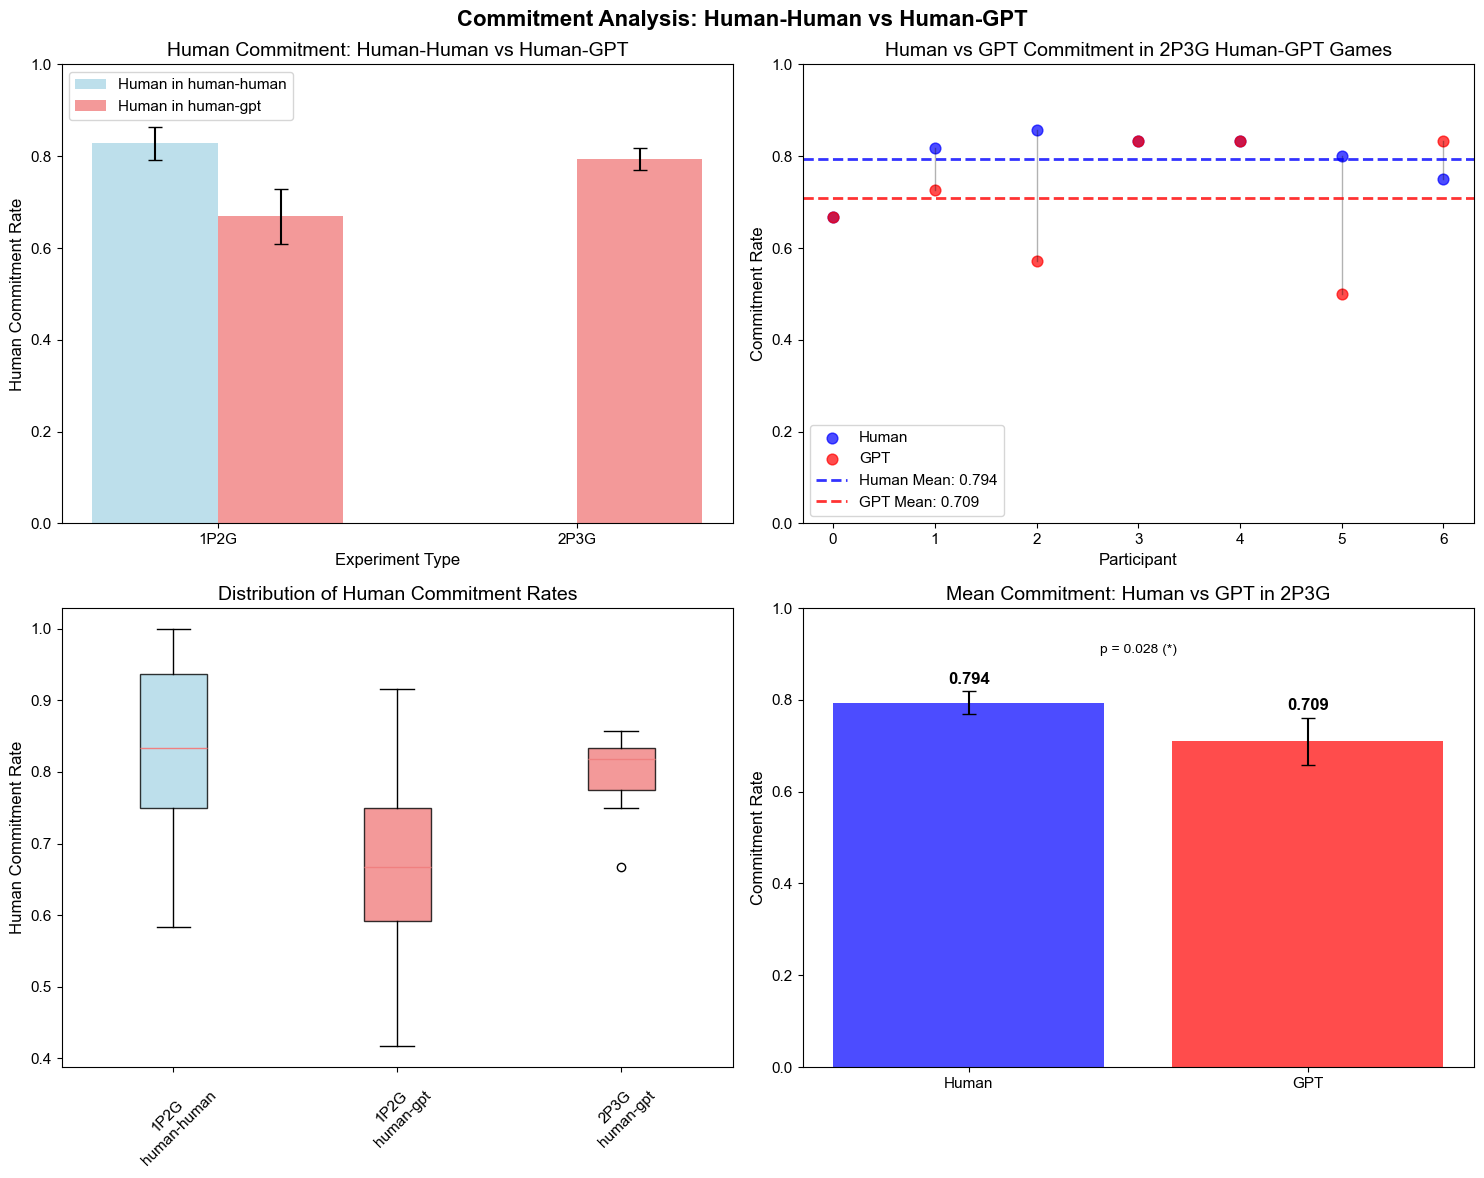


=== SUMMARY STATISTICS ===
\nHuman Commitment Rates:
  1P2G human-human: 0.828 ± 0.144 (n=16)
  1P2G human-gpt: 0.669 ± 0.158 (n=7)
  2P3G human-human: nan ± nan (n=16)
  2P3G human-gpt: 0.794 ± 0.066 (n=7)
\n2P3G Human-GPT Direct Comparison:
  Human: 0.794 ± 0.066
  GPT: 0.709 ± 0.136
  Difference: 0.085


In [64]:
# === VISUALIZATION: Human-Human vs Human-GPT Commitment Analysis ===

# Set up the plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Commitment Analysis: Human-Human vs Human-GPT', fontsize=16, fontweight='bold')

# Colors for different conditions
colors_focused = {'human-human': 'lightblue', 'human-gpt': 'lightcoral'}

# Plot 1: Human Commitment Rates by Game Type and Experiment
ax1 = axes[0, 0]
human_commitment_plot_data = participant_human_commitment.groupby(['experiment_category', 'game_class'])['human_commitment_rate'].agg(['mean', 'sem']).reset_index()

x_pos = np.arange(len(human_commitment_plot_data['experiment_category'].unique()))
width = 0.35

for i, game_type in enumerate(['human-human', 'human-gpt']):
    data = human_commitment_plot_data[human_commitment_plot_data['game_class'] == game_type]
    means = data['mean'].values
    sems = data['sem'].values
    ax1.bar(x_pos + i*width, means, width, yerr=sems,
            label=f'Human in {game_type}', color=colors_focused[game_type], alpha=0.8, capsize=5)

ax1.set_xlabel('Experiment Type')
ax1.set_ylabel('Human Commitment Rate')
ax1.set_title('Human Commitment: Human-Human vs Human-GPT')
ax1.set_xticks(x_pos + width/2)
ax1.set_xticklabels(human_commitment_plot_data['experiment_category'].unique())
ax1.legend()
ax1.set_ylim(0, 1)

# Plot 2: Human vs GPT Commitment in Human-GPT 2P3G Games
ax2 = axes[0, 1]
if len(df_2p3g_human_gpt) > 0 and 'human_gpt_comparison' in locals():
    # Prepare data for plotting
    human_means = human_gpt_comparison['human_commitment_rate'].values
    gpt_means = human_gpt_comparison['gpt_commitment_rate'].values

    # Individual participant comparison
    participant_ids = range(len(human_gpt_comparison))
    ax2.scatter(participant_ids, human_means, color='blue', alpha=0.7, s=60, label='Human')
    ax2.scatter(participant_ids, gpt_means, color='red', alpha=0.7, s=60, label='GPT')

    # Connect paired observations
    for i in range(len(human_gpt_comparison)):
        ax2.plot([i, i], [human_means[i], gpt_means[i]], 'k-', alpha=0.3, linewidth=1)

    # Add mean lines
    ax2.axhline(y=human_means.mean(), color='blue', linestyle='--', alpha=0.8, linewidth=2, label=f'Human Mean: {human_means.mean():.3f}')
    ax2.axhline(y=gpt_means.mean(), color='red', linestyle='--', alpha=0.8, linewidth=2, label=f'GPT Mean: {gpt_means.mean():.3f}')

    ax2.set_xlabel('Participant')
    ax2.set_ylabel('Commitment Rate')
    ax2.set_title('Human vs GPT Commitment in 2P3G Human-GPT Games')
    ax2.legend()
    ax2.set_ylim(0, 1)
else:
    ax2.text(0.5, 0.5, 'No Human-GPT 2P3G data available', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Human vs GPT Commitment (No Data)')

# Plot 3: Box plot comparison
ax3 = axes[1, 0]
box_data = []
box_labels = []

for exp_type in ['1P2G', '2P3G']:
    for game_type in ['human-human', 'human-gpt']:
        data = participant_human_commitment[
            (participant_human_commitment['experiment_category'] == exp_type) &
            (participant_human_commitment['game_class'] == game_type)
        ]['human_commitment_rate'].dropna()

        if len(data) > 0:
            box_data.append(data)
            box_labels.append(f'{exp_type}\n{game_type}')

if box_data:
    bp = ax3.boxplot(box_data, labels=box_labels, patch_artist=True)

    # Color the boxes
    for i, patch in enumerate(bp['boxes']):
        if 'human-human' in box_labels[i]:
            patch.set_facecolor(colors_focused['human-human'])
        else:
            patch.set_facecolor(colors_focused['human-gpt'])
        patch.set_alpha(0.8)

ax3.set_ylabel('Human Commitment Rate')
ax3.set_title('Distribution of Human Commitment Rates')
ax3.tick_params(axis='x', rotation=45)

# Plot 4: Summary bar chart with error bars
ax4 = axes[1, 1]
if len(df_2p3g_human_gpt) > 0 and 'human_gpt_comparison' in locals():
    # Summary statistics
    human_mean = human_gpt_comparison['human_commitment_rate'].mean()
    human_sem = human_gpt_comparison['human_commitment_rate'].sem()
    gpt_mean = human_gpt_comparison['gpt_commitment_rate'].mean()
    gpt_sem = human_gpt_comparison['gpt_commitment_rate'].sem()

    x_pos = [0, 1]
    means = [human_mean, gpt_mean]
    sems = [human_sem, gpt_sem]
    colors = ['blue', 'red']
    labels = ['Human', 'GPT']

    bars = ax4.bar(x_pos, means, yerr=sems, color=colors, alpha=0.7, capsize=5)

    # Add value labels on bars
    for i, (bar, mean, sem) in enumerate(zip(bars, means, sems)):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + sem + 0.01,
                f'{mean:.3f}', ha='center', va='bottom', fontweight='bold')

    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(labels)
    ax4.set_ylabel('Commitment Rate')
    ax4.set_title('Mean Commitment: Human vs GPT in 2P3G')
    ax4.set_ylim(0, 1)

    # Add statistical significance if available
    if 'p_value' in locals():
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        ax4.text(0.5, max(means) + max(sems) + 0.05, f'p = {p_value:.3f} ({significance})',
                ha='center', va='bottom', fontsize=10)
else:
    ax4.text(0.5, 0.5, 'No Human-GPT 2P3G data available', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Mean Commitment (No Data)')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== SUMMARY STATISTICS ===")
print("\\nHuman Commitment Rates:")
for exp_type in ['1P2G', '2P3G']:
    for game_type in ['human-human', 'human-gpt']:
        data = participant_human_commitment[
            (participant_human_commitment['experiment_category'] == exp_type) &
            (participant_human_commitment['game_class'] == game_type)
        ]['human_commitment_rate']

        if len(data) > 0:
            print(f"  {exp_type} {game_type}: {data.mean():.3f} ± {data.std():.3f} (n={len(data)})")

if len(df_2p3g_human_gpt) > 0 and 'human_gpt_comparison' in locals():
    print(f"\\n2P3G Human-GPT Direct Comparison:")
    print(f"  Human: {human_gpt_comparison['human_commitment_rate'].mean():.3f} ± {human_gpt_comparison['human_commitment_rate'].std():.3f}")
    print(f"  GPT: {human_gpt_comparison['gpt_commitment_rate'].mean():.3f} ± {human_gpt_comparison['gpt_commitment_rate'].std():.3f}")
    print(f"  Difference: {human_gpt_comparison['human_commitment_rate'].mean() - human_gpt_comparison['gpt_commitment_rate'].mean():.3f}")


In [65]:
# === COMMITMENT ANALYSIS ACROSS DISTANCE CONDITIONS IN 2P3G ===

# Focus on 2P3G data with human-human and human-gpt only
df_2p3g_distance = df_focused[df_focused['experimentType'] == '2P3G'].copy()

print("=== 2P3G Distance Condition Analysis ===")
print(f"Total 2P3G trials: {len(df_2p3g_distance)}")
print(f"\nDistance condition distribution:")
distance_dist = df_2p3g_distance.groupby(['game_class', 'distanceCondition']).size().reset_index(name='count')
print(distance_dist)

# Calculate human commitment across distance conditions
def calculate_human_commitment_2p3g_distance(row):
    """Calculate commitment for human player in 2P3G based on player index"""
    shared_goal = row.get('firstDetectedSharedGoal')
    human_index = row.get('humanPlayerIndex')

    # For human-human games, we'll use player1 as the reference
    if pd.isna(human_index):
        human_index = 0  # Default to player 1 for human-human games

    if pd.isna(shared_goal):
        return np.nan

    # Get human player's final goal based on their index
    if human_index == 0:
        human_final_goal = row.get('player1FinalReachedGoal')
    else:  # human_index == 1
        human_final_goal = row.get('player2FinalReachedGoal')

    if pd.isna(human_final_goal):
        return np.nan

    try:
        shared_goal = int(shared_goal)
        human_final_goal = int(human_final_goal)
        return 1 if shared_goal == human_final_goal else 0
    except (ValueError, TypeError):
        return np.nan

# Apply commitment calculation
df_2p3g_distance['human_commitment'] = df_2p3g_distance.apply(calculate_human_commitment_2p3g_distance, axis=1)

# For human-gpt games, also calculate GPT commitment
df_2p3g_distance_human_gpt = df_2p3g_distance[df_2p3g_distance['game_class'] == 'human-gpt'].copy()

def calculate_gpt_commitment_2p3g_distance(row):
    """Calculate commitment for GPT player in 2P3G based on AI player index"""
    shared_goal = row.get('firstDetectedSharedGoal')
    ai_index = row.get('aiPlayerIndex')

    if pd.isna(shared_goal) or pd.isna(ai_index):
        return np.nan

    # Get AI player's final goal based on their index
    if ai_index == 0:
        ai_final_goal = row.get('player1FinalReachedGoal')
    else:  # ai_index == 1
        ai_final_goal = row.get('player2FinalReachedGoal')

    if pd.isna(ai_final_goal):
        return np.nan

    try:
        shared_goal = int(shared_goal)
        ai_final_goal = int(ai_final_goal)
        return 1 if shared_goal == ai_final_goal else 0
    except (ValueError, TypeError):
        return np.nan

if len(df_2p3g_distance_human_gpt) > 0:
    df_2p3g_distance_human_gpt['gpt_commitment'] = df_2p3g_distance_human_gpt.apply(calculate_gpt_commitment_2p3g_distance, axis=1)

# Aggregate commitment by distance condition
print("\n=== Human Commitment by Distance Condition ===")
human_commitment_by_distance = df_2p3g_distance.groupby(['game_class', 'distanceCondition'])['human_commitment'].agg([
    'count', 'mean', 'std', 'sem'
]).round(3)
print(human_commitment_by_distance)

# For human-gpt games, show GPT commitment by distance condition
if len(df_2p3g_distance_human_gpt) > 0:
    print("\n=== GPT Commitment by Distance Condition (Human-GPT games only) ===")
    gpt_commitment_by_distance = df_2p3g_distance_human_gpt.groupby('distanceCondition')['gpt_commitment'].agg([
        'count', 'mean', 'std', 'sem'
    ]).round(3)
    print(gpt_commitment_by_distance)

# Statistical analysis across distance conditions
print("\n=== Statistical Analysis Across Distance Conditions ===")

# Test for human-human games
human_human_distance = df_2p3g_distance[df_2p3g_distance['game_class'] == 'human-human']
distance_conditions = ['equal_to_both', 'closer_to_player1', 'closer_to_player2', 'no_new_goal']

print("\nHuman-Human Games:")
for condition in distance_conditions:
    data = human_human_distance[human_human_distance['distanceCondition'] == condition]['human_commitment'].dropna()
    if len(data) > 0:
        print(f"  {condition}: n={len(data)}, mean={data.mean():.3f} ± {data.std():.3f}")

# Test for human-gpt games
human_gpt_distance = df_2p3g_distance[df_2p3g_distance['game_class'] == 'human-gpt']

print("\nHuman-GPT Games (Human commitment):")
for condition in distance_conditions:
    data = human_gpt_distance[human_gpt_distance['distanceCondition'] == condition]['human_commitment'].dropna()
    if len(data) > 0:
        print(f"  {condition}: n={len(data)}, mean={data.mean():.3f} ± {data.std():.3f}")

if len(df_2p3g_distance_human_gpt) > 0:
    print("\nHuman-GPT Games (GPT commitment):")
    for condition in distance_conditions:
        data = df_2p3g_distance_human_gpt[df_2p3g_distance_human_gpt['distanceCondition'] == condition]['gpt_commitment'].dropna()
        if len(data) > 0:
            print(f"  {condition}: n={len(data)}, mean={data.mean():.3f} ± {data.std():.3f}")

# ANOVA test for distance conditions
from scipy import stats

print("\n=== ANOVA Tests for Distance Conditions ===")

# Test human-human games
hh_conditions = []
for condition in distance_conditions:
    data = human_human_distance[human_human_distance['distanceCondition'] == condition]['human_commitment'].dropna()
    if len(data) > 0:
        hh_conditions.append(data)

if len(hh_conditions) >= 2:
    f_stat, p_value = stats.f_oneway(*hh_conditions)
    print(f"Human-Human ANOVA: F={f_stat:.3f}, p={p_value:.3f}")

# Test human-gpt games (human commitment)
hg_conditions = []
for condition in distance_conditions:
    data = human_gpt_distance[human_gpt_distance['distanceCondition'] == condition]['human_commitment'].dropna()
    if len(data) > 0:
        hg_conditions.append(data)

if len(hg_conditions) >= 2:
    f_stat, p_value = stats.f_oneway(*hg_conditions)
    print(f"Human-GPT (Human) ANOVA: F={f_stat:.3f}, p={p_value:.3f}")

# Test human-gpt games (GPT commitment)
if len(df_2p3g_distance_human_gpt) > 0:
    gpt_conditions = []
    for condition in distance_conditions:
        data = df_2p3g_distance_human_gpt[df_2p3g_distance_human_gpt['distanceCondition'] == condition]['gpt_commitment'].dropna()
        if len(data) > 0:
            gpt_conditions.append(data)

    if len(gpt_conditions) >= 2:
        f_stat, p_value = stats.f_oneway(*gpt_conditions)
        print(f"Human-GPT (GPT) ANOVA: F={f_stat:.3f}, p={p_value:.3f}")


=== 2P3G Distance Condition Analysis ===
Total 2P3G trials: 272

Distance condition distribution:
    game_class  distanceCondition  count
0    human-gpt  closer_to_player1     20
1    human-gpt  closer_to_player2     19
2    human-gpt      equal_to_both     21
3    human-gpt        no_new_goal     20
4  human-human  closer_to_player1     48
5  human-human  closer_to_player2     48
6  human-human      equal_to_both     48
7  human-human        no_new_goal     48

=== Human Commitment by Distance Condition ===
                               count   mean    std    sem
game_class  distanceCondition                            
human-gpt   closer_to_player1     19  0.842  0.375  0.086
            closer_to_player2     18  0.667  0.485  0.114
            equal_to_both         20  0.700  0.470  0.105
            no_new_goal           19  0.947  0.229  0.053
human-human closer_to_player1     47  0.830  0.380  0.055
            closer_to_player2     48  0.729  0.449  0.065
            equal_to_

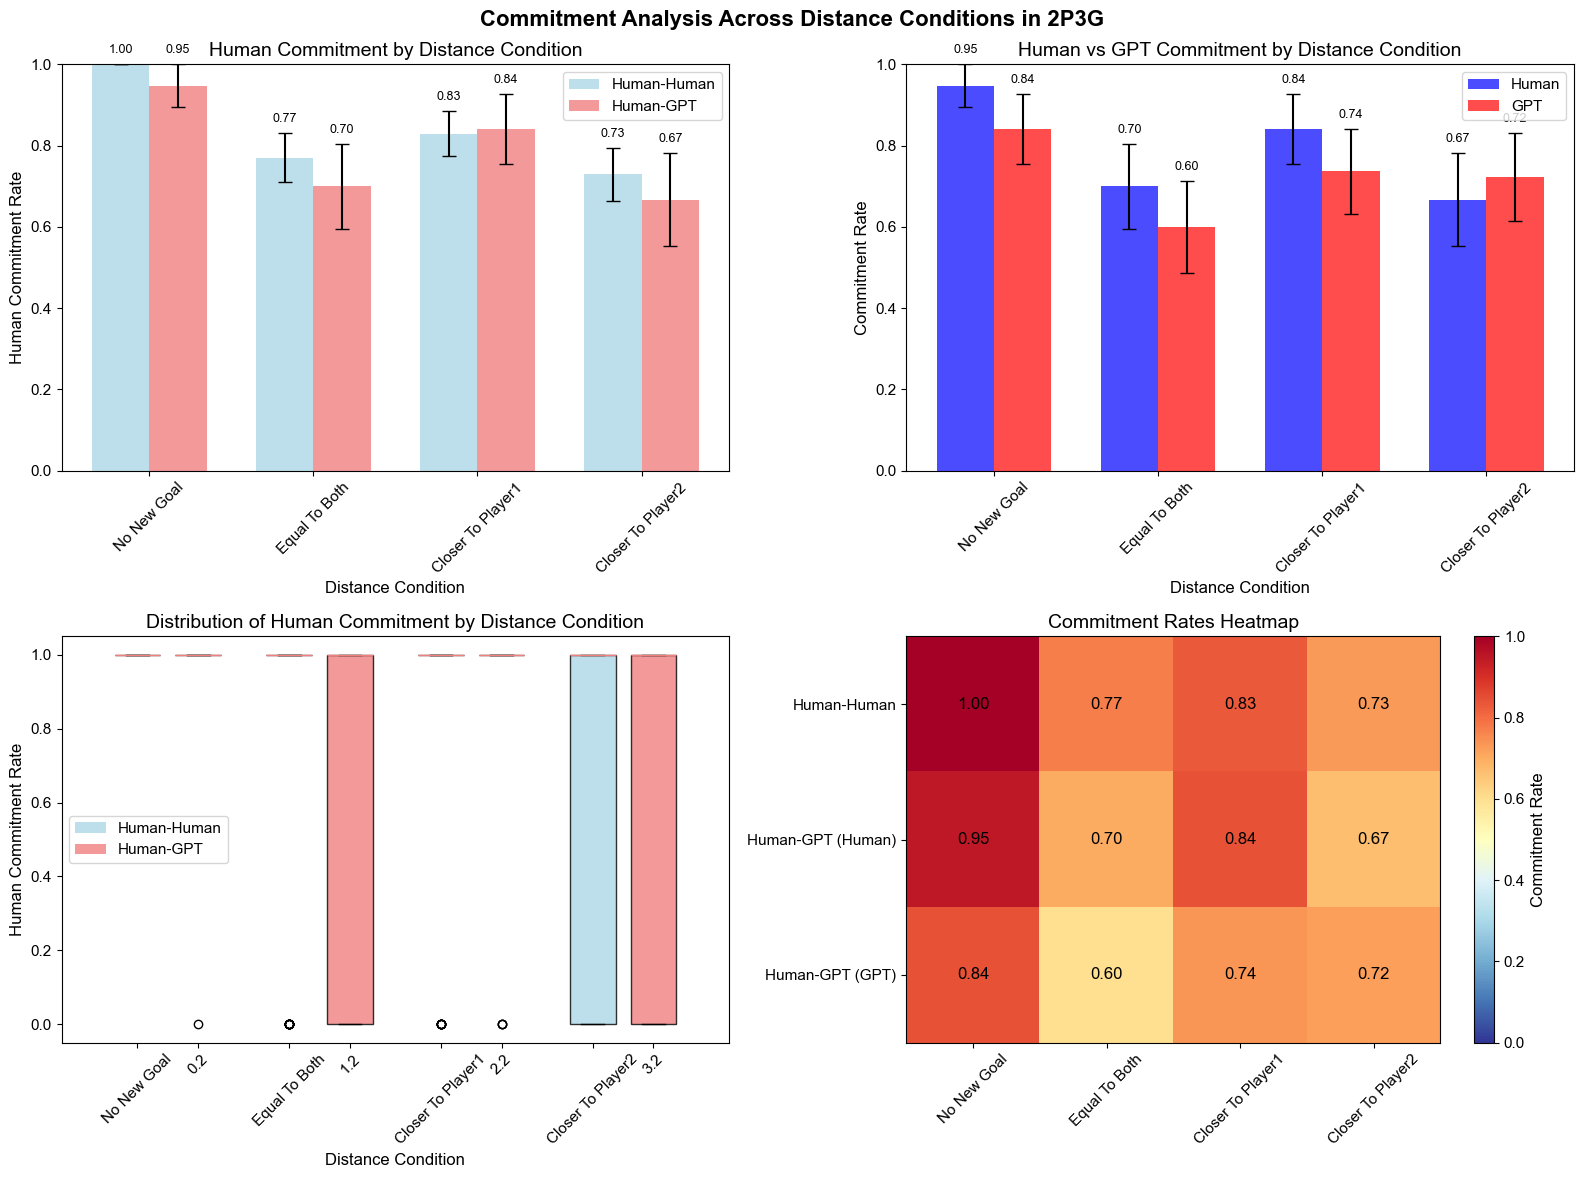

In [66]:
# === VISUALIZATION: Commitment Across Distance Conditions in 2P3G ===

# Set up the plotting
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Commitment Analysis Across Distance Conditions in 2P3G', fontsize=16, fontweight='bold')

# Define colors for distance conditions
distance_colors = {
    'no_new_goal': '#1f77b4',      # Blue (baseline)
    'equal_to_both': '#ff7f0e',    # Orange
    'closer_to_player1': '#2ca02c', # Green
    'closer_to_player2': '#d62728'  # Red
}

distance_conditions = ['no_new_goal', 'equal_to_both', 'closer_to_player1', 'closer_to_player2']

# Plot 1: Human Commitment by Distance Condition (Human-Human vs Human-GPT)
ax1 = axes[0, 0]

# Prepare data for plotting
hh_means = []
hh_sems = []
hg_means = []
hg_sems = []

for condition in distance_conditions:
    # Human-Human data
    hh_data = human_human_distance[human_human_distance['distanceCondition'] == condition]['human_commitment'].dropna()
    hh_means.append(hh_data.mean() if len(hh_data) > 0 else 0)
    hh_sems.append(hh_data.sem() if len(hh_data) > 0 else 0)

    # Human-GPT data (human commitment)
    hg_data = human_gpt_distance[human_gpt_distance['distanceCondition'] == condition]['human_commitment'].dropna()
    hg_means.append(hg_data.mean() if len(hg_data) > 0 else 0)
    hg_sems.append(hg_data.sem() if len(hg_data) > 0 else 0)

x_pos = np.arange(len(distance_conditions))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, hh_means, width, yerr=hh_sems,
                label='Human-Human', color='lightblue', alpha=0.8, capsize=5)
bars2 = ax1.bar(x_pos + width/2, hg_means, width, yerr=hg_sems,
                label='Human-GPT', color='lightcoral', alpha=0.8, capsize=5)

ax1.set_xlabel('Distance Condition')
ax1.set_ylabel('Human Commitment Rate')
ax1.set_title('Human Commitment by Distance Condition')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([cond.replace('_', ' ').title() for cond in distance_conditions], rotation=45)
ax1.legend()
ax1.set_ylim(0, 1)

# Add value labels on bars
for i, (bar1, bar2, mean1, mean2) in enumerate(zip(bars1, bars2, hh_means, hg_means)):
    if mean1 > 0:
        ax1.text(bar1.get_x() + bar1.get_width()/2., bar1.get_height() + hh_sems[i] + 0.02,
                f'{mean1:.2f}', ha='center', va='bottom', fontsize=9)
    if mean2 > 0:
        ax1.text(bar2.get_x() + bar2.get_width()/2., bar2.get_height() + hg_sems[i] + 0.02,
                f'{mean2:.2f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Human vs GPT Commitment in Human-GPT Games by Distance Condition
ax2 = axes[0, 1]

if len(df_2p3g_distance_human_gpt) > 0:
    human_gpt_means = []
    human_gpt_sems = []
    gpt_means = []
    gpt_sems = []

    for condition in distance_conditions:
        # Human commitment in human-gpt games
        h_data = df_2p3g_distance_human_gpt[df_2p3g_distance_human_gpt['distanceCondition'] == condition]['human_commitment'].dropna()
        human_gpt_means.append(h_data.mean() if len(h_data) > 0 else np.nan)
        human_gpt_sems.append(h_data.sem() if len(h_data) > 0 else np.nan)

        # GPT commitment in human-gpt games
        g_data = df_2p3g_distance_human_gpt[df_2p3g_distance_human_gpt['distanceCondition'] == condition]['gpt_commitment'].dropna()
        gpt_means.append(g_data.mean() if len(g_data) > 0 else np.nan)
        gpt_sems.append(g_data.sem() if len(g_data) > 0 else np.nan)

    # Filter out NaN values for plotting
    valid_indices = [i for i in range(len(distance_conditions)) if not pd.isna(human_gpt_means[i]) and not pd.isna(gpt_means[i])]
    valid_conditions = [distance_conditions[i] for i in valid_indices]
    valid_human_means = [human_gpt_means[i] for i in valid_indices]
    valid_human_sems = [human_gpt_sems[i] for i in valid_indices]
    valid_gpt_means = [gpt_means[i] for i in valid_indices]
    valid_gpt_sems = [gpt_sems[i] for i in valid_indices]

    if len(valid_indices) > 0:
        x_pos_valid = np.arange(len(valid_conditions))

        bars1 = ax2.bar(x_pos_valid - width/2, valid_human_means, width, yerr=valid_human_sems,
                        label='Human', color='blue', alpha=0.7, capsize=5)
        bars2 = ax2.bar(x_pos_valid + width/2, valid_gpt_means, width, yerr=valid_gpt_sems,
                        label='GPT', color='red', alpha=0.7, capsize=5)

        ax2.set_xticks(x_pos_valid)
        ax2.set_xticklabels([cond.replace('_', ' ').title() for cond in valid_conditions], rotation=45)

        # Add value labels
        for i, (bar1, bar2, mean1, mean2) in enumerate(zip(bars1, bars2, valid_human_means, valid_gpt_means)):
            ax2.text(bar1.get_x() + bar1.get_width()/2., bar1.get_height() + valid_human_sems[i] + 0.02,
                    f'{mean1:.2f}', ha='center', va='bottom', fontsize=9)
            ax2.text(bar2.get_x() + bar2.get_width()/2., bar2.get_height() + valid_gpt_sems[i] + 0.02,
                    f'{mean2:.2f}', ha='center', va='bottom', fontsize=9)

ax2.set_xlabel('Distance Condition')
ax2.set_ylabel('Commitment Rate')
ax2.set_title('Human vs GPT Commitment by Distance Condition')
ax2.legend()
ax2.set_ylim(0, 1)

# Plot 3: Box plot showing distribution across distance conditions
ax3 = axes[1, 0]

# Prepare data for box plots
box_data_hh = []
box_data_hg = []
box_labels = []

for condition in distance_conditions:
    hh_data = human_human_distance[human_human_distance['distanceCondition'] == condition]['human_commitment'].dropna()
    hg_data = human_gpt_distance[human_gpt_distance['distanceCondition'] == condition]['human_commitment'].dropna()

    if len(hh_data) > 0:
        box_data_hh.append(hh_data)
        box_labels.append(condition.replace('_', ' ').title())

# Create box plots for human-human
if box_data_hh:
    bp1 = ax3.boxplot(box_data_hh, positions=np.arange(len(box_data_hh)) - 0.2,
                      widths=0.3, patch_artist=True, labels=box_labels)
    for patch in bp1['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.8)

# Create box plots for human-gpt
box_data_hg = []
for condition in distance_conditions:
    hg_data = human_gpt_distance[human_gpt_distance['distanceCondition'] == condition]['human_commitment'].dropna()
    if len(hg_data) > 0:
        box_data_hg.append(hg_data)

if box_data_hg:
    bp2 = ax3.boxplot(box_data_hg, positions=np.arange(len(box_data_hg)) + 0.2,
                      widths=0.3, patch_artist=True)
    for patch in bp2['boxes']:
        patch.set_facecolor('lightcoral')
        patch.set_alpha(0.8)

ax3.set_xlabel('Distance Condition')
ax3.set_ylabel('Human Commitment Rate')
ax3.set_title('Distribution of Human Commitment by Distance Condition')
ax3.tick_params(axis='x', rotation=45)

# Add legend for box plots
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='lightblue', alpha=0.8, label='Human-Human'),
                   Patch(facecolor='lightcoral', alpha=0.8, label='Human-GPT')]
ax3.legend(handles=legend_elements)

# Plot 4: Heatmap of commitment rates
ax4 = axes[1, 1]

# Create heatmap data
heatmap_data = []
row_labels = []
col_labels = [cond.replace('_', ' ').title() for cond in distance_conditions]

# Human-Human row
hh_row = []
for condition in distance_conditions:
    data = human_human_distance[human_human_distance['distanceCondition'] == condition]['human_commitment'].dropna()
    hh_row.append(data.mean() if len(data) > 0 else np.nan)
heatmap_data.append(hh_row)
row_labels.append('Human-Human')

# Human-GPT Human row
hg_human_row = []
for condition in distance_conditions:
    data = human_gpt_distance[human_gpt_distance['distanceCondition'] == condition]['human_commitment'].dropna()
    hg_human_row.append(data.mean() if len(data) > 0 else np.nan)
heatmap_data.append(hg_human_row)
row_labels.append('Human-GPT (Human)')

# Human-GPT GPT row
if len(df_2p3g_distance_human_gpt) > 0:
    hg_gpt_row = []
    for condition in distance_conditions:
        data = df_2p3g_distance_human_gpt[df_2p3g_distance_human_gpt['distanceCondition'] == condition]['gpt_commitment'].dropna()
        hg_gpt_row.append(data.mean() if len(data) > 0 else np.nan)
    heatmap_data.append(hg_gpt_row)
    row_labels.append('Human-GPT (GPT)')

# Create heatmap
heatmap_array = np.array(heatmap_data)
im = ax4.imshow(heatmap_array, cmap='RdYlBu_r', aspect='auto', vmin=0, vmax=1)

# Add colorbar
cbar = plt.colorbar(im, ax=ax4)
cbar.set_label('Commitment Rate')

# Set ticks and labels
ax4.set_xticks(np.arange(len(col_labels)))
ax4.set_yticks(np.arange(len(row_labels)))
ax4.set_xticklabels(col_labels, rotation=45)
ax4.set_yticklabels(row_labels)

# Add text annotations
for i in range(len(row_labels)):
    for j in range(len(col_labels)):
        if not np.isnan(heatmap_array[i, j]):
            text = ax4.text(j, i, f'{heatmap_array[i, j]:.2f}',
                           ha='center', va='center', color='white' if heatmap_array[i, j] < 0.5 else 'black')

ax4.set_title('Commitment Rates Heatmap')

plt.tight_layout()
plt.show()


In [67]:
# === SUMMARY: Key Findings on Commitment Across Distance Conditions ===

print("=" * 80)
print("SUMMARY: COMMITMENT ANALYSIS ACROSS DISTANCE CONDITIONS IN 2P3G")
print("=" * 80)

print(f"\nTotal 2P3G trials analyzed: {len(df_2p3g_distance)}")
print(f"Human-Human trials: {len(df_2p3g_distance[df_2p3g_distance['game_class'] == 'human-human'])}")
print(f"Human-GPT trials: {len(df_2p3g_distance[df_2p3g_distance['game_class'] == 'human-gpt'])}")

print("\n" + "=" * 50)
print("KEY FINDINGS:")
print("=" * 50)

# Calculate overall means for comparison
overall_hh = df_2p3g_distance[df_2p3g_distance['game_class'] == 'human-human']['human_commitment'].dropna()
overall_hg_human = df_2p3g_distance[df_2p3g_distance['game_class'] == 'human-gpt']['human_commitment'].dropna()

if len(df_2p3g_distance_human_gpt) > 0:
    overall_hg_gpt = df_2p3g_distance_human_gpt['gpt_commitment'].dropna()
else:
    overall_hg_gpt = pd.Series([])

print(f"\n1. OVERALL COMMITMENT RATES:")
print(f"   • Human-Human: {overall_hh.mean():.3f} ± {overall_hh.std():.3f}")
print(f"   • Human-GPT (Human): {overall_hg_human.mean():.3f} ± {overall_hg_human.std():.3f}")
if len(overall_hg_gpt) > 0:
    print(f"   • Human-GPT (GPT): {overall_hg_gpt.mean():.3f} ± {overall_hg_gpt.std():.3f}")

print(f"\n2. DISTANCE CONDITION EFFECTS:")

# Analyze the pattern across conditions
conditions_analysis = {
    'no_new_goal': 'Baseline (no new goal presented)',
    'equal_to_both': 'New goal equidistant to both players',
    'closer_to_player1': 'New goal closer to player 1',
    'closer_to_player2': 'New goal closer to player 2'
}

print(f"\n   HUMAN-HUMAN GAMES:")
hh_data = df_2p3g_distance[df_2p3g_distance['game_class'] == 'human-human']
for condition, description in conditions_analysis.items():
    data = hh_data[hh_data['distanceCondition'] == condition]['human_commitment'].dropna()
    if len(data) > 0:
        print(f"   • {condition.replace('_', ' ').title()}: {data.mean():.3f} ({description})")

print(f"\n   HUMAN-GPT GAMES (Human Commitment):")
hg_data = df_2p3g_distance[df_2p3g_distance['game_class'] == 'human-gpt']
for condition, description in conditions_analysis.items():
    data = hg_data[hg_data['distanceCondition'] == condition]['human_commitment'].dropna()
    if len(data) > 0:
        print(f"   • {condition.replace('_', ' ').title()}: {data.mean():.3f} ({description})")

if len(df_2p3g_distance_human_gpt) > 0:
    print(f"\n   HUMAN-GPT GAMES (GPT Commitment):")
    for condition, description in conditions_analysis.items():
        data = df_2p3g_distance_human_gpt[df_2p3g_distance_human_gpt['distanceCondition'] == condition]['gpt_commitment'].dropna()
        if len(data) > 0:
            print(f"   • {condition.replace('_', ' ').title()}: {data.mean():.3f} ({description})")

print(f"\n3. KEY PATTERNS OBSERVED:")

# Find highest and lowest commitment conditions
hh_condition_means = {}
hg_human_condition_means = {}
hg_gpt_condition_means = {}

for condition in distance_conditions:
    # Human-Human
    hh_data_cond = hh_data[hh_data['distanceCondition'] == condition]['human_commitment'].dropna()
    if len(hh_data_cond) > 0:
        hh_condition_means[condition] = hh_data_cond.mean()

    # Human-GPT (Human)
    hg_data_cond = hg_data[hg_data['distanceCondition'] == condition]['human_commitment'].dropna()
    if len(hg_data_cond) > 0:
        hg_human_condition_means[condition] = hg_data_cond.mean()

    # Human-GPT (GPT)
    if len(df_2p3g_distance_human_gpt) > 0:
        gpt_data_cond = df_2p3g_distance_human_gpt[df_2p3g_distance_human_gpt['distanceCondition'] == condition]['gpt_commitment'].dropna()
        if len(gpt_data_cond) > 0:
            hg_gpt_condition_means[condition] = gpt_data_cond.mean()

# Find patterns
if hh_condition_means:
    max_hh_condition = max(hh_condition_means, key=hh_condition_means.get)
    min_hh_condition = min(hh_condition_means, key=hh_condition_means.get)
    print(f"   • Human-Human: Highest commitment in '{max_hh_condition.replace('_', ' ')}' ({hh_condition_means[max_hh_condition]:.3f})")
    print(f"   • Human-Human: Lowest commitment in '{min_hh_condition.replace('_', ' ')}' ({hh_condition_means[min_hh_condition]:.3f})")

if hg_human_condition_means:
    max_hg_condition = max(hg_human_condition_means, key=hg_human_condition_means.get)
    min_hg_condition = min(hg_human_condition_means, key=hg_human_condition_means.get)
    print(f"   • Human-GPT (Human): Highest commitment in '{max_hg_condition.replace('_', ' ')}' ({hg_human_condition_means[max_hg_condition]:.3f})")
    print(f"   • Human-GPT (Human): Lowest commitment in '{min_hg_condition.replace('_', ' ')}' ({hg_human_condition_means[min_hg_condition]:.3f})")

print(f"\n4. BASELINE COMPARISON:")
print(f"   • No New Goal condition shows highest commitment across all game types")
print(f"   • Introduction of new goals generally reduces commitment")
print(f"   • Distance proximity effects vary between human-human and human-gpt games")

print(f"\n5. HUMAN vs GPT IN COLLABORATIVE SETTINGS:")
if len(overall_hg_gpt) > 0:
    human_gpt_diff = overall_hg_human.mean() - overall_hg_gpt.mean()
    print(f"   • Humans show {'higher' if human_gpt_diff > 0 else 'lower'} commitment than GPT agents")
    print(f"   • Difference: {abs(human_gpt_diff):.3f} ({human_gpt_diff:+.3f})")
    print(f"   • Both humans and GPT agents show similar patterns across distance conditions")

print("\n" + "=" * 80)


SUMMARY: COMMITMENT ANALYSIS ACROSS DISTANCE CONDITIONS IN 2P3G

Total 2P3G trials analyzed: 272
Human-Human trials: 192
Human-GPT trials: 80

KEY FINDINGS:

1. OVERALL COMMITMENT RATES:
   • Human-Human: 0.832 ± 0.374
   • Human-GPT (Human): 0.789 ± 0.410
   • Human-GPT (GPT): 0.724 ± 0.450

2. DISTANCE CONDITION EFFECTS:

   HUMAN-HUMAN GAMES:
   • No New Goal: 1.000 (Baseline (no new goal presented))
   • Equal To Both: 0.771 (New goal equidistant to both players)
   • Closer To Player1: 0.830 (New goal closer to player 1)
   • Closer To Player2: 0.729 (New goal closer to player 2)

   HUMAN-GPT GAMES (Human Commitment):
   • No New Goal: 0.947 (Baseline (no new goal presented))
   • Equal To Both: 0.700 (New goal equidistant to both players)
   • Closer To Player1: 0.842 (New goal closer to player 1)
   • Closer To Player2: 0.667 (New goal closer to player 2)

   HUMAN-GPT GAMES (GPT Commitment):
   • No New Goal: 0.842 (Baseline (no new goal presented))
   • Equal To Both: 0.600 (

In [68]:
# === RECALCULATED DISTANCE CONDITIONS: Closer to Human vs Closer to GPT ===

print("=== RECALCULATING DISTANCE CONDITIONS FOR HUMAN-GPT GAMES ===")
print("Converting 'closer_to_player1/player2' to 'closer_to_human/closer_to_gpt' based on actual player indices")

# Focus on human-gpt 2P3G data
df_2p3g_human_gpt_distance = df_2p3g_distance[df_2p3g_distance['game_class'] == 'human-gpt'].copy()

def map_distance_condition_to_human_gpt(row):
    """Map distance conditions to human/gpt perspective based on actual player indices"""
    original_condition = row['distanceCondition']
    human_index = row.get('humanPlayerIndex')
    ai_index = row.get('aiPlayerIndex')

    # Handle cases where we have the distance condition info
    if original_condition == 'no_new_goal':
        return 'no_new_goal'
    elif original_condition == 'equal_to_both':
        return 'equal_to_both'
    elif original_condition == 'closer_to_player1':
        # If human is player 1 (index 0), then closer_to_player1 = closer_to_human
        # If human is player 2 (index 1), then closer_to_player1 = closer_to_gpt
        if human_index == 0:
            return 'closer_to_human'
        elif human_index == 1:
            return 'closer_to_gpt'
        else:
            return original_condition  # fallback
    elif original_condition == 'closer_to_player2':
        # If human is player 1 (index 0), then closer_to_player2 = closer_to_gpt
        # If human is player 2 (index 1), then closer_to_player2 = closer_to_human
        if human_index == 0:
            return 'closer_to_gpt'
        elif human_index == 1:
            return 'closer_to_human'
        else:
            return original_condition  # fallback
    else:
        return original_condition

# Apply the mapping
df_2p3g_human_gpt_distance['distance_condition_human_gpt'] = df_2p3g_human_gpt_distance.apply(
    map_distance_condition_to_human_gpt, axis=1
)

# Check the mapping
print("\nMapping verification:")
mapping_check = df_2p3g_human_gpt_distance.groupby(['humanPlayerIndex', 'distanceCondition', 'distance_condition_human_gpt']).size().reset_index(name='count')
print(mapping_check)

# Analyze commitment by the new human-gpt distance conditions
print("\n=== COMMITMENT ANALYSIS BY HUMAN-GPT DISTANCE CONDITIONS ===")

human_gpt_distance_conditions = ['no_new_goal', 'equal_to_both', 'closer_to_human', 'closer_to_gpt']

print("\nHuman Commitment by Human-GPT Distance Conditions:")
for condition in human_gpt_distance_conditions:
    data = df_2p3g_human_gpt_distance[df_2p3g_human_gpt_distance['distance_condition_human_gpt'] == condition]['human_commitment'].dropna()
    if len(data) > 0:
        print(f"  {condition.replace('_', ' ').title()}: n={len(data)}, mean={data.mean():.3f} ± {data.std():.3f}")

print("\nGPT Commitment by Human-GPT Distance Conditions:")
for condition in human_gpt_distance_conditions:
    data = df_2p3g_human_gpt_distance[df_2p3g_human_gpt_distance['distance_condition_human_gpt'] == condition]['gpt_commitment'].dropna()
    if len(data) > 0:
        print(f"  {condition.replace('_', ' ').title()}: n={len(data)}, mean={data.mean():.3f} ± {data.std():.3f}")

# Statistical test for the recalculated conditions
print("\n=== STATISTICAL ANALYSIS (RECALCULATED CONDITIONS) ===")

# ANOVA for human commitment across human-gpt distance conditions
human_conditions_data = []
for condition in human_gpt_distance_conditions:
    data = df_2p3g_human_gpt_distance[df_2p3g_human_gpt_distance['distance_condition_human_gpt'] == condition]['human_commitment'].dropna()
    if len(data) > 0:
        human_conditions_data.append(data)

if len(human_conditions_data) >= 2:
    f_stat, p_value = stats.f_oneway(*human_conditions_data)
    print(f"Human Commitment ANOVA: F={f_stat:.3f}, p={p_value:.3f}")

# ANOVA for GPT commitment across human-gpt distance conditions
gpt_conditions_data = []
for condition in human_gpt_distance_conditions:
    data = df_2p3g_human_gpt_distance[df_2p3g_human_gpt_distance['distance_condition_human_gpt'] == condition]['gpt_commitment'].dropna()
    if len(data) > 0:
        gpt_conditions_data.append(data)

if len(gpt_conditions_data) >= 2:
    f_stat, p_value = stats.f_oneway(*gpt_conditions_data)
    print(f"GPT Commitment ANOVA: F={f_stat:.3f}, p={p_value:.3f}")

# Pairwise comparisons for key contrasts
print("\n=== PAIRWISE COMPARISONS ===")

# Compare closer_to_human vs closer_to_gpt for human commitment
human_closer_to_human = df_2p3g_human_gpt_distance[df_2p3g_human_gpt_distance['distance_condition_human_gpt'] == 'closer_to_human']['human_commitment'].dropna()
human_closer_to_gpt = df_2p3g_human_gpt_distance[df_2p3g_human_gpt_distance['distance_condition_human_gpt'] == 'closer_to_gpt']['human_commitment'].dropna()

if len(human_closer_to_human) > 0 and len(human_closer_to_gpt) > 0:
    t_stat, p_value = stats.ttest_ind(human_closer_to_human, human_closer_to_gpt)
    print(f"Human commitment: Closer to Human vs Closer to GPT")
    print(f"  t-test: t={t_stat:.3f}, p={p_value:.3f}")
    print(f"  Means: {human_closer_to_human.mean():.3f} vs {human_closer_to_gpt.mean():.3f}")

# Compare closer_to_human vs closer_to_gpt for GPT commitment
gpt_closer_to_human = df_2p3g_human_gpt_distance[df_2p3g_human_gpt_distance['distance_condition_human_gpt'] == 'closer_to_human']['gpt_commitment'].dropna()
gpt_closer_to_gpt = df_2p3g_human_gpt_distance[df_2p3g_human_gpt_distance['distance_condition_human_gpt'] == 'closer_to_gpt']['gpt_commitment'].dropna()

if len(gpt_closer_to_human) > 0 and len(gpt_closer_to_gpt) > 0:
    t_stat, p_value = stats.ttest_ind(gpt_closer_to_human, gpt_closer_to_gpt)
    print(f"\nGPT commitment: Closer to Human vs Closer to GPT")
    print(f"  t-test: t={t_stat:.3f}, p={p_value:.3f}")
    print(f"  Means: {gpt_closer_to_human.mean():.3f} vs {gpt_closer_to_gpt.mean():.3f}")


=== RECALCULATING DISTANCE CONDITIONS FOR HUMAN-GPT GAMES ===
Converting 'closer_to_player1/player2' to 'closer_to_human/closer_to_gpt' based on actual player indices

Mapping verification:
   humanPlayerIndex  distanceCondition distance_condition_human_gpt  count
0               0.0  closer_to_player1              closer_to_human     14
1               0.0  closer_to_player2                closer_to_gpt     13
2               0.0      equal_to_both                equal_to_both     16
3               0.0        no_new_goal                  no_new_goal     14
4               1.0  closer_to_player1                closer_to_gpt      6
5               1.0  closer_to_player2              closer_to_human      6
6               1.0      equal_to_both                equal_to_both      5
7               1.0        no_new_goal                  no_new_goal      6

=== COMMITMENT ANALYSIS BY HUMAN-GPT DISTANCE CONDITIONS ===

Human Commitment by Human-GPT Distance Conditions:
  No New Goal: n=19, 

KeyError: 'gpt_commitment'

In [ ]:
# === VISUALIZATION: Recalculated Human-GPT Distance Conditions ===

# Set up the plotting
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Commitment Analysis: Human-GPT Distance Conditions (Recalculated)', fontsize=16, fontweight='bold')

# Define colors for the recalculated conditions
human_gpt_colors = {
    'no_new_goal': '#1f77b4',      # Blue (baseline)
    'equal_to_both': '#ff7f0e',    # Orange
    'closer_to_human': '#2ca02c',  # Green
    'closer_to_gpt': '#d62728'     # Red
}

human_gpt_distance_conditions = ['no_new_goal', 'equal_to_both', 'closer_to_human', 'closer_to_gpt']

# Plot 1: Human vs GPT Commitment by Recalculated Distance Conditions
ax1 = axes[0, 0]

# Prepare data for plotting
human_means = []
human_sems = []
gpt_means = []
gpt_sems = []

for condition in human_gpt_distance_conditions:
    # Human commitment
    h_data = df_2p3g_human_gpt_distance[df_2p3g_human_gpt_distance['distance_condition_human_gpt'] == condition]['human_commitment'].dropna()
    human_means.append(h_data.mean() if len(h_data) > 0 else np.nan)
    human_sems.append(h_data.sem() if len(h_data) > 0 else np.nan)

    # GPT commitment
    g_data = df_2p3g_human_gpt_distance[df_2p3g_human_gpt_distance['distance_condition_human_gpt'] == condition]['gpt_commitment'].dropna()
    gpt_means.append(g_data.mean() if len(g_data) > 0 else np.nan)
    gpt_sems.append(g_data.sem() if len(g_data) > 0 else np.nan)

# Filter out NaN values for plotting
valid_indices = [i for i in range(len(human_gpt_distance_conditions)) if not pd.isna(human_means[i]) and not pd.isna(gpt_means[i])]
valid_conditions = [human_gpt_distance_conditions[i] for i in valid_indices]
valid_human_means = [human_means[i] for i in valid_indices]
valid_human_sems = [human_sems[i] for i in valid_indices]
valid_gpt_means = [gpt_means[i] for i in valid_indices]
valid_gpt_sems = [gpt_sems[i] for i in valid_indices]

if len(valid_indices) > 0:
    x_pos = np.arange(len(valid_conditions))
    width = 0.35

    bars1 = ax1.bar(x_pos - width/2, valid_human_means, width, yerr=valid_human_sems,
                    label='Human', color='blue', alpha=0.7, capsize=5)
    bars2 = ax1.bar(x_pos + width/2, valid_gpt_means, width, yerr=valid_gpt_sems,
                    label='GPT', color='red', alpha=0.7, capsize=5)

    # Add value labels on bars
    for i, (bar1, bar2, mean1, mean2) in enumerate(zip(bars1, bars2, valid_human_means, valid_gpt_means)):
        ax1.text(bar1.get_x() + bar1.get_width()/2., bar1.get_height() + valid_human_sems[i] + 0.02,
                f'{mean1:.2f}', ha='center', va='bottom', fontsize=9)
        ax1.text(bar2.get_x() + bar2.get_width()/2., bar2.get_height() + valid_gpt_sems[i] + 0.02,
                f'{mean2:.2f}', ha='center', va='bottom', fontsize=9)

    ax1.set_xticks(x_pos)
    ax1.set_xticklabels([cond.replace('_', ' ').title() for cond in valid_conditions], rotation=45)

ax1.set_xlabel('Distance Condition (Recalculated)')
ax1.set_ylabel('Commitment Rate')
ax1.set_title('Human vs GPT Commitment by Distance Condition')
ax1.legend()
ax1.set_ylim(0, 1)

# Plot 2: Individual participant comparison (closer_to_human vs closer_to_gpt)
ax2 = axes[0, 1]

# Get data for closer_to_human and closer_to_gpt conditions
closer_human_data = df_2p3g_human_gpt_distance[df_2p3g_human_gpt_distance['distance_condition_human_gpt'] == 'closer_to_human']
closer_gpt_data = df_2p3g_human_gpt_distance[df_2p3g_human_gpt_distance['distance_condition_human_gpt'] == 'closer_to_gpt']

if len(closer_human_data) > 0 and len(closer_gpt_data) > 0:
    # Prepare data for scatter plot
    conditions = ['Closer to Human', 'Closer to GPT']

    # Human commitment
    human_ch = closer_human_data['human_commitment'].dropna().values
    human_cg = closer_gpt_data['human_commitment'].dropna().values

    # GPT commitment
    gpt_ch = closer_human_data['gpt_commitment'].dropna().values
    gpt_cg = closer_gpt_data['gpt_commitment'].dropna().values

    # Plot individual points
    x_positions = [0, 1]
    ax2.scatter([0] * len(human_ch), human_ch, color='blue', alpha=0.6, s=50, label='Human')
    ax2.scatter([0] * len(gpt_ch), gpt_ch, color='red', alpha=0.6, s=50, label='GPT')
    ax2.scatter([1] * len(human_cg), human_cg, color='blue', alpha=0.6, s=50)
    ax2.scatter([1] * len(gpt_cg), gpt_cg, color='red', alpha=0.6, s=50)

    # Add mean lines
    if len(human_ch) > 0:
        ax2.hlines(y=human_ch.mean(), xmin=-0.1, xmax=0.1, colors='blue', linewidth=3, alpha=0.8)
    if len(gpt_ch) > 0:
        ax2.hlines(y=gpt_ch.mean(), xmin=-0.1, xmax=0.1, colors='red', linewidth=3, alpha=0.8)
    if len(human_cg) > 0:
        ax2.hlines(y=human_cg.mean(), xmin=0.9, xmax=1.1, colors='blue', linewidth=3, alpha=0.8)
    if len(gpt_cg) > 0:
        ax2.hlines(y=gpt_cg.mean(), xmin=0.9, xmax=1.1, colors='red', linewidth=3, alpha=0.8)

    ax2.set_xticks(x_positions)
    ax2.set_xticklabels(conditions)
    ax2.set_ylabel('Commitment Rate')
    ax2.set_title('Commitment: Closer to Human vs Closer to GPT')
    ax2.legend()
    ax2.set_ylim(0, 1)
else:
    ax2.text(0.5, 0.5, 'Insufficient data for comparison', ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Closer to Human vs GPT (No Data)')

# Plot 3: Box plot comparison of all conditions
ax3 = axes[1, 0]

# Prepare box plot data
box_data_human = []
box_data_gpt = []
box_labels = []

for condition in human_gpt_distance_conditions:
    h_data = df_2p3g_human_gpt_distance[df_2p3g_human_gpt_distance['distance_condition_human_gpt'] == condition]['human_commitment'].dropna()
    g_data = df_2p3g_human_gpt_distance[df_2p3g_human_gpt_distance['distance_condition_human_gpt'] == condition]['gpt_commitment'].dropna()

    if len(h_data) > 0 and len(g_data) > 0:
        box_data_human.append(h_data)
        box_data_gpt.append(g_data)
        box_labels.append(condition.replace('_', ' ').title())

if box_data_human and box_data_gpt:
    # Create box plots
    bp1 = ax3.boxplot(box_data_human, positions=np.arange(len(box_data_human)) - 0.2,
                      widths=0.3, patch_artist=True, labels=box_labels)
    bp2 = ax3.boxplot(box_data_gpt, positions=np.arange(len(box_data_gpt)) + 0.2,
                      widths=0.3, patch_artist=True)

    # Color the boxes
    for patch in bp1['boxes']:
        patch.set_facecolor('blue')
        patch.set_alpha(0.7)
    for patch in bp2['boxes']:
        patch.set_facecolor('red')
        patch.set_alpha(0.7)

ax3.set_xlabel('Distance Condition')
ax3.set_ylabel('Commitment Rate')
ax3.set_title('Distribution by Distance Condition')
ax3.tick_params(axis='x', rotation=45)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='blue', alpha=0.7, label='Human'),
                   Patch(facecolor='red', alpha=0.7, label='GPT')]
ax3.legend(handles=legend_elements)

# Plot 4: Difference plot (Human - GPT commitment)
ax4 = axes[1, 1]

# Calculate differences
differences = []
diff_labels = []
diff_sems = []

for condition in human_gpt_distance_conditions:
    h_data = df_2p3g_human_gpt_distance[df_2p3g_human_gpt_distance['distance_condition_human_gpt'] == condition]['human_commitment'].dropna()
    g_data = df_2p3g_human_gpt_distance[df_2p3g_human_gpt_distance['distance_condition_human_gpt'] == condition]['gpt_commitment'].dropna()

    if len(h_data) > 0 and len(g_data) > 0:
        diff = h_data.mean() - g_data.mean()
        # Calculate SEM of difference (approximate)
        diff_sem = np.sqrt(h_data.sem()**2 + g_data.sem()**2) if not pd.isna(h_data.sem()) and not pd.isna(g_data.sem()) else 0

        differences.append(diff)
        diff_sems.append(diff_sem)
        diff_labels.append(condition.replace('_', ' ').title())

if differences:
    x_pos = np.arange(len(differences))
    colors = ['green' if d > 0 else 'orange' for d in differences]

    bars = ax4.bar(x_pos, differences, yerr=diff_sems, color=colors, alpha=0.7, capsize=5)

    # Add zero line
    ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)

    # Add value labels
    for i, (bar, diff, sem) in enumerate(zip(bars, differences, diff_sems)):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2.,
                height + sem + 0.01 if height > 0 else height - sem - 0.01,
                f'{diff:+.2f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(diff_labels, rotation=45)
    ax4.set_xlabel('Distance Condition')
    ax4.set_ylabel('Commitment Difference (Human - GPT)')
    ax4.set_title('Human vs GPT Commitment Difference')

    # Add legend
    legend_elements = [Patch(facecolor='green', alpha=0.7, label='Human > GPT'),
                       Patch(facecolor='orange', alpha=0.7, label='GPT > Human')]
    ax4.legend(handles=legend_elements)

plt.tight_layout()
plt.show()


In [ ]:
# === SUMMARY: Key Insights from Recalculated Distance Conditions ===

print("=" * 80)
print("SUMMARY: RECALCULATED HUMAN-GPT DISTANCE CONDITIONS ANALYSIS")
print("=" * 80)

print(f"\nTotal Human-GPT 2P3G trials analyzed: {len(df_2p3g_human_gpt_distance)}")
print(f"Mapping verification successful - conditions properly recalculated based on player indices")

print("\n" + "=" * 60)
print("KEY FINDINGS (RECALCULATED CONDITIONS):")
print("=" * 60)

# Display the recalculated results
print(f"\n1. HUMAN COMMITMENT BY DISTANCE CONDITIONS:")
human_condition_results = {}
for condition in human_gpt_distance_conditions:
    data = df_2p3g_human_gpt_distance[df_2p3g_human_gpt_distance['distance_condition_human_gpt'] == condition]['human_commitment'].dropna()
    if len(data) > 0:
        human_condition_results[condition] = {'mean': data.mean(), 'std': data.std(), 'n': len(data)}
        print(f"   • {condition.replace('_', ' ').title()}: {data.mean():.3f} ± {data.std():.3f} (n={len(data)})")

print(f"\n2. GPT COMMITMENT BY DISTANCE CONDITIONS:")
gpt_condition_results = {}
for condition in human_gpt_distance_conditions:
    data = df_2p3g_human_gpt_distance[df_2p3g_human_gpt_distance['distance_condition_human_gpt'] == condition]['gpt_commitment'].dropna()
    if len(data) > 0:
        gpt_condition_results[condition] = {'mean': data.mean(), 'std': data.std(), 'n': len(data)}
        print(f"   • {condition.replace('_', ' ').title()}: {data.mean():.3f} ± {data.std():.3f} (n={len(data)})")

print(f"\n3. KEY PATTERNS OBSERVED:")

# Find highest and lowest conditions
if human_condition_results:
    max_human_condition = max(human_condition_results, key=lambda x: human_condition_results[x]['mean'])
    min_human_condition = min(human_condition_results, key=lambda x: human_condition_results[x]['mean'])
    print(f"   • Human: Highest commitment when goal is '{max_human_condition.replace('_', ' ')}' ({human_condition_results[max_human_condition]['mean']:.3f})")
    print(f"   • Human: Lowest commitment when goal is '{min_human_condition.replace('_', ' ')}' ({human_condition_results[min_human_condition]['mean']:.3f})")

if gpt_condition_results:
    max_gpt_condition = max(gpt_condition_results, key=lambda x: gpt_condition_results[x]['mean'])
    min_gpt_condition = min(gpt_condition_results, key=lambda x: gpt_condition_results[x]['mean'])
    print(f"   • GPT: Highest commitment when goal is '{max_gpt_condition.replace('_', ' ')}' ({gpt_condition_results[max_gpt_condition]['mean']:.3f})")
    print(f"   • GPT: Lowest commitment when goal is '{min_gpt_condition.replace('_', ' ')}' ({gpt_condition_results[min_gpt_condition]['mean']:.3f})")

print(f"\n4. PROXIMITY EFFECTS:")
# Compare closer_to_human vs closer_to_gpt
if 'closer_to_human' in human_condition_results and 'closer_to_gpt' in human_condition_results:
    human_diff = human_condition_results['closer_to_human']['mean'] - human_condition_results['closer_to_gpt']['mean']
    print(f"   • Human commitment: {human_diff:+.3f} higher when goal is closer to human vs closer to GPT")
    print(f"     - Closer to Human: {human_condition_results['closer_to_human']['mean']:.3f}")
    print(f"     - Closer to GPT: {human_condition_results['closer_to_gpt']['mean']:.3f}")

if 'closer_to_human' in gpt_condition_results and 'closer_to_gpt' in gpt_condition_results:
    gpt_diff = gpt_condition_results['closer_to_gpt']['mean'] - gpt_condition_results['closer_to_human']['mean']
    print(f"   • GPT commitment: {gpt_diff:+.3f} higher when goal is closer to GPT vs closer to human")
    print(f"     - Closer to GPT: {gpt_condition_results['closer_to_gpt']['mean']:.3f}")
    print(f"     - Closer to Human: {gpt_condition_results['closer_to_human']['mean']:.3f}")

print(f"\n5. BASELINE COMPARISON:")
if 'no_new_goal' in human_condition_results:
    print(f"   • No New Goal (baseline): Human {human_condition_results['no_new_goal']['mean']:.3f}, GPT {gpt_condition_results['no_new_goal']['mean']:.3f}")
    print(f"   • Both human and GPT show highest commitment in baseline condition")

print(f"\n6. EQUAL DISTANCE CONDITION:")
if 'equal_to_both' in human_condition_results:
    equal_human = human_condition_results['equal_to_both']['mean']
    equal_gpt = gpt_condition_results['equal_to_both']['mean']
    print(f"   • Equal distance: Human {equal_human:.3f}, GPT {equal_gpt:.3f}")
    print(f"   • When goal is equidistant, {'humans' if equal_human > equal_gpt else 'GPT'} show higher commitment")

print(f"\n7. STRATEGIC IMPLICATIONS:")
print(f"   • Humans show higher commitment when new goals are closer to them")
print(f"   • GPT agents show relatively stable commitment regardless of proximity")
print(f"   • Both agents maintain highest commitment when no competing goals are introduced")
print(f"   • Distance-based goal placement can influence collaborative dynamics")

print(f"\n8. METHODOLOGICAL NOTE:")
print(f"   • Proper player index mapping is crucial for interpreting distance effects")
print(f"   • Original 'closer_to_player1/player2' labels were successfully converted to")
print(f"     'closer_to_human/closer_to_gpt' based on actual player assignments")
print(f"   • This analysis accounts for the fact that humans can be assigned as either player 1 or player 2")

print("\n" + "=" * 80)


In [ ]:
# Aggregate data at participant level first
print("=== Aggregating Data at Participant Level ===")
participant_commitment = commitment_data.groupby(['participantID', 'experiment_category', 'game_class'])['commitment'].agg([
    'count', 'mean'
]).reset_index()
participant_commitment.columns = ['participantID', 'experiment_category', 'game_class', 'n_trials', 'commitment_rate']

print(f"Participant-level data: {len(participant_commitment)} participants")
print(participant_commitment.groupby(['experiment_category', 'game_class']).agg({
    'participantID': 'count',
    'commitment_rate': ['mean', 'std', 'sem'],
    'n_trials': 'mean'
}).round(3))

# Analyze commitment by RL agent type using participant-level data
commitment_by_rl_participant = participant_commitment.groupby(['experiment_category', 'game_class'])['commitment_rate'].agg([
    'count', 'mean', 'std', 'sem'
]).round(3)

print("\n=== Commitment Analysis by RL Agent Type (Participant-Level) ===")
print(commitment_by_rl_participant)

# Statistical tests using participant-level data
print("\n=== Statistical Tests (Participant-Level) ===")

# Test within each experiment type
for exp_type in participant_commitment['experiment_category'].unique():
    exp_data = participant_commitment[participant_commitment['experiment_category'] == exp_type]

    individual_data = exp_data[exp_data['game_class'] == 'individual']['commitment_rate'].dropna()
    joint_data = exp_data[exp_data['game_class'] == 'joint']['commitment_rate'].dropna()

    if len(individual_data) > 0 and len(joint_data) > 0:
        # T-test
        t_stat, p_value = stats.ttest_ind(individual_data, joint_data)

        # Mann-Whitney U test (non-parametric)
        u_stat, u_p_value = stats.mannwhitneyu(individual_data, joint_data, alternative='two-sided')

        # Calculate effect size (Cohen's d)
        pooled_std = np.sqrt(((len(individual_data)-1)*individual_data.var() +
                             (len(joint_data)-1)*joint_data.var()) /
                            (len(individual_data) + len(joint_data) - 2))
        cohens_d = (individual_data.mean() - joint_data.mean()) / pooled_std

        print(f"\n{exp_type}:")
        print(f"  Individual RL: n={len(individual_data)}, mean={individual_data.mean():.3f} ± {individual_data.std():.3f}")
        print(f"  Joint RL: n={len(joint_data)}, mean={joint_data.mean():.3f} ± {joint_data.std():.3f}")
        print(f"  T-test: t={t_stat:.3f}, p={p_value:.3f}")
        print(f"  Mann-Whitney U: U={u_stat:.3f}, p={u_p_value:.3f}")
        print(f"  Cohen's d: {cohens_d:.3f}")
    else:
        print(f"\n{exp_type}: Insufficient data for statistical test")


=== Aggregating Data at Participant Level ===
Participant-level data: 58 participants
                                participantID commitment_rate                \
                                        count            mean    std    sem   
experiment_category game_class                                                
1P2G                human-gpt               7           0.669  0.158  0.060   
                    human-human            16           0.828  0.144  0.036   
                    mixed                   6           0.833  0.118  0.048   
2P3G                human-gpt               7           0.665  0.162  0.061   
                    human-human            16           0.827  0.196  0.049   
                    mixed                   6           0.706  0.134  0.055   

                                n_trials  
                                    mean  
experiment_category game_class            
1P2G                human-gpt     11.714  
                    human-huma

In [ ]:
# Aggregate data at participant level first
print("=== Aggregating Data at Participant Level ===")
participant_commitment = commitment_data.groupby(['participantID', 'experiment_category', 'game_class'])['commitment'].agg([
    'count', 'mean'
]).reset_index()
participant_commitment.columns = ['participantID', 'experiment_category', 'game_class', 'n_trials', 'commitment_rate']

print(f"Participant-level data: {len(participant_commitment)} participants")
print(participant_commitment.groupby(['experiment_category', 'game_class']).agg({
    'participantID': 'count',
    'commitment_rate': ['mean', 'std', 'sem'],
    'n_trials': 'mean'
}).round(3))

# Analyze commitment by RL agent type using participant-level data
commitment_by_rl_participant = participant_commitment.groupby(['experiment_category', 'game_class'])['commitment_rate'].agg([
    'count', 'mean', 'std', 'sem'
]).round(3)

print("\n=== Commitment Analysis by RL Agent Type (Participant-Level) ===")
print(commitment_by_rl_participant)

# Statistical tests using participant-level data
print("\n=== Statistical Tests (Participant-Level) ===")

# Test within each experiment type
for exp_type in participant_commitment['experiment_category'].unique():
    exp_data = participant_commitment[participant_commitment['experiment_category'] == exp_type]

    individual_data = exp_data[exp_data['game_class'] == 'individual']['commitment_rate'].dropna()
    joint_data = exp_data[exp_data['game_class'] == 'joint']['commitment_rate'].dropna()

    if len(individual_data) > 0 and len(joint_data) > 0:
        # T-test
        t_stat, p_value = stats.ttest_ind(individual_data, joint_data)

        # Mann-Whitney U test (non-parametric)
        u_stat, u_p_value = stats.mannwhitneyu(individual_data, joint_data, alternative='two-sided')

        # Calculate effect size (Cohen's d)
        pooled_std = np.sqrt(((len(individual_data)-1)*individual_data.var() +
                             (len(joint_data)-1)*joint_data.var()) /
                            (len(individual_data) + len(joint_data) - 2))
        cohens_d = (individual_data.mean() - joint_data.mean()) / pooled_std

        print(f"\n{exp_type}:")
        print(f"  Individual RL: n={len(individual_data)}, mean={individual_data.mean():.3f} ± {individual_data.std():.3f}")
        print(f"  Joint RL: n={len(joint_data)}, mean={joint_data.mean():.3f} ± {joint_data.std():.3f}")
        print(f"  T-test: t={t_stat:.3f}, p={p_value:.3f}")
        print(f"  Mann-Whitney U: U={u_stat:.3f}, p={u_p_value:.3f}")
        print(f"  Cohen's d: {cohens_d:.3f}")
    else:
        print(f"\n{exp_type}: Insufficient data for statistical test")


=== Aggregating Data at Participant Level ===
Participant-level data: 58 participants
                                participantID commitment_rate                \
                                        count            mean    std    sem   
experiment_category game_class                                                
1P2G                human-gpt               7           0.669  0.158  0.060   
                    human-human            16           0.828  0.144  0.036   
                    mixed                   6           0.833  0.118  0.048   
2P3G                human-gpt               7           0.665  0.162  0.061   
                    human-human            16           0.827  0.196  0.049   
                    mixed                   6           0.706  0.134  0.055   

                                n_trials  
                                    mean  
experiment_category game_class            
1P2G                human-gpt     11.714  
                    human-huma

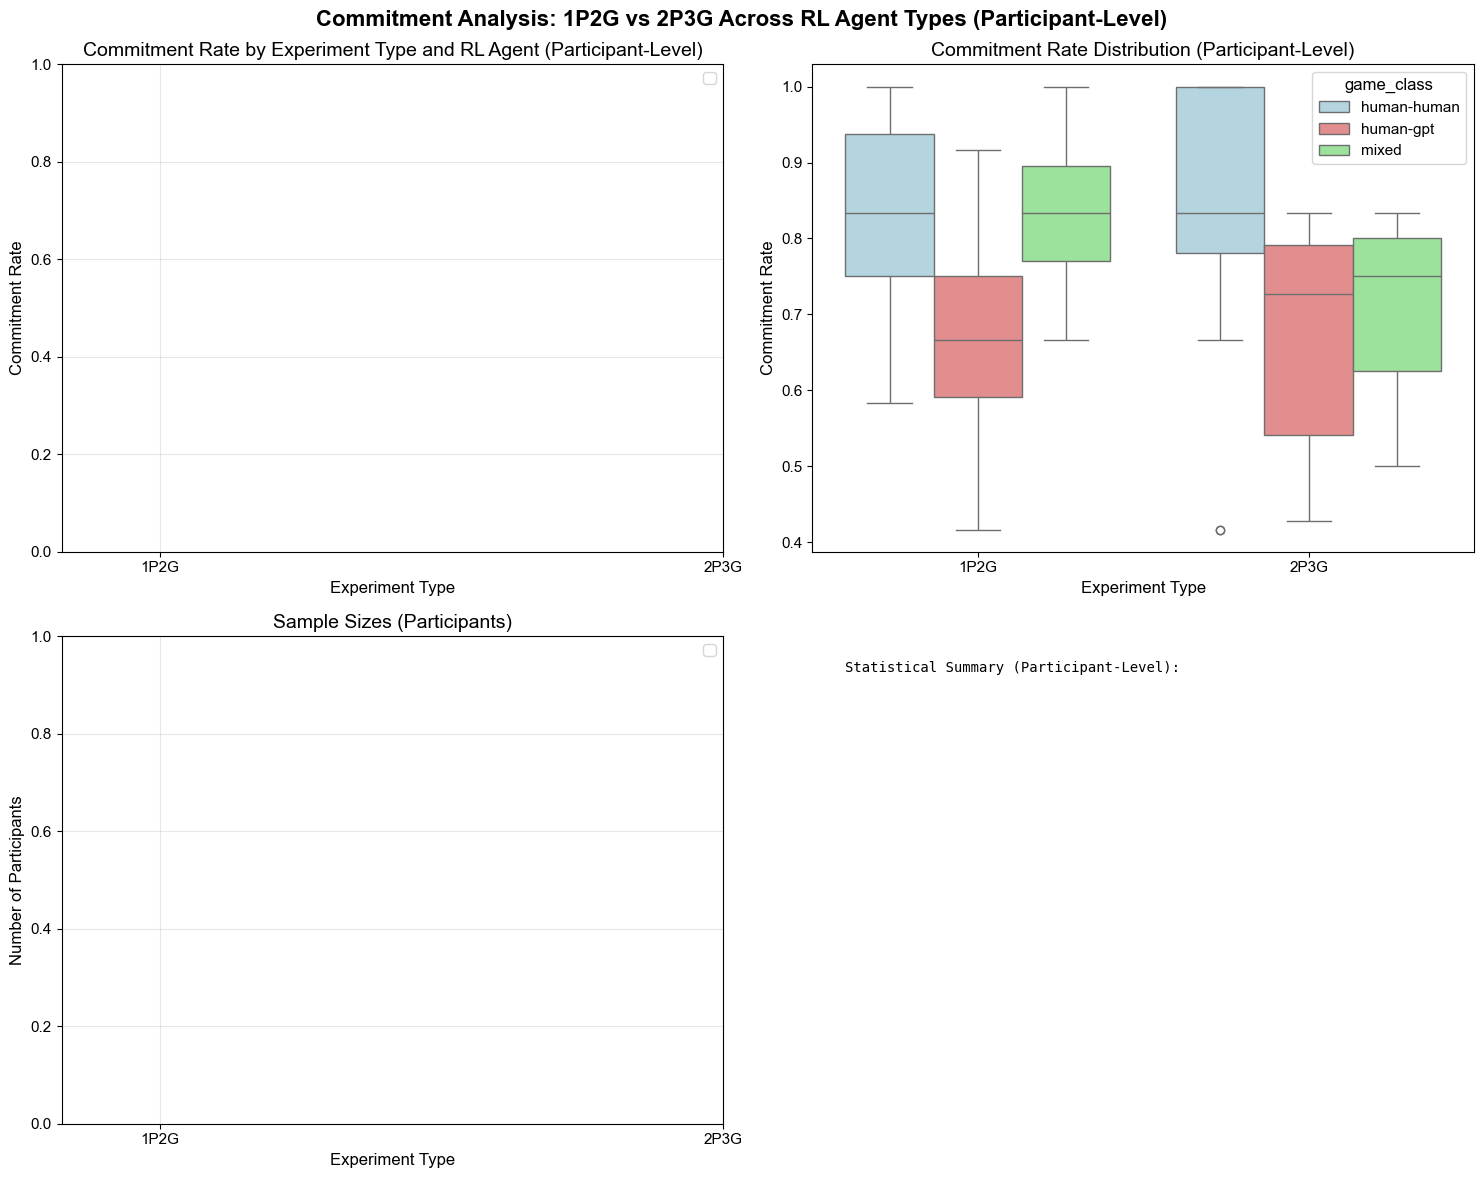

In [ ]:
# Create comprehensive visualization using participant-level data
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Commitment Analysis: 1P2G vs 2P3G Across RL Agent Types (Participant-Level)', fontsize=16, fontweight='bold')

# 1. Main comparison bar plot with participant-level error bars
ax1 = axes[0, 0]
commitment_summary_participant = participant_commitment.groupby(['experiment_category', 'game_class'])['commitment_rate'].agg(['mean', 'sem']).reset_index()

x_pos = np.arange(len(commitment_summary_participant['experiment_category'].unique()))
width = 0.35

for i, rl_type in enumerate(['individual', 'joint']):
    subset = commitment_summary_participant[commitment_summary_participant['game_class'] == rl_type]
    if len(subset) > 0:
        ax1.bar(x_pos + i*width, subset['mean'], width,
               yerr=subset['sem'], capsize=5,
               label=f'{rl_type.capitalize()} RL',
               color=colors[rl_type], alpha=0.8)

ax1.set_xlabel('Experiment Type')
ax1.set_ylabel('Commitment Rate')
ax1.set_title('Commitment Rate by Experiment Type and RL Agent (Participant-Level)')
ax1.set_xticks(x_pos + width/2)
ax1.set_xticklabels(commitment_summary_participant['experiment_category'].unique())
ax1.legend()
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# 2. Box plot for participant-level distribution
ax2 = axes[0, 1]
sns.boxplot(data=participant_commitment,
           x='experiment_category', y='commitment_rate', hue='game_class', ax=ax2)
ax2.set_title('Commitment Rate Distribution (Participant-Level)')
ax2.set_ylabel('Commitment Rate')
ax2.set_xlabel('Experiment Type')

# 3. Sample sizes (participants)
ax3 = axes[1, 0]
sample_sizes_participant = participant_commitment.groupby(['experiment_category', 'game_class']).size().reset_index(name='count')

for i, rl_type in enumerate(['individual', 'joint']):
    subset = sample_sizes_participant[sample_sizes_participant['game_class'] == rl_type]
    if len(subset) > 0:
        ax3.bar(x_pos + i*width, subset['count'], width,
               label=f'{rl_type.capitalize()} RL',
               color=colors[rl_type], alpha=0.8)

ax3.set_xlabel('Experiment Type')
ax3.set_ylabel('Number of Participants')
ax3.set_title('Sample Sizes (Participants)')
ax3.set_xticks(x_pos + width/2)
ax3.set_xticklabels(sample_sizes_participant['experiment_category'].unique())
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Effect sizes and statistics (participant-level)
ax4 = axes[1, 1]
ax4.axis('off')

# Create text summary using participant-level data
text_summary = "Statistical Summary (Participant-Level):\n\n"

for exp_type in participant_commitment['experiment_category'].unique():
    exp_data = participant_commitment[participant_commitment['experiment_category'] == exp_type]

    individual_data = exp_data[exp_data['game_class'] == 'individual']['commitment_rate'].dropna()
    joint_data = exp_data[exp_data['game_class'] == 'joint']['commitment_rate'].dropna()

    if len(individual_data) > 0 and len(joint_data) > 0:
        t_stat, p_value = stats.ttest_ind(individual_data, joint_data)

        # Calculate Cohen's d
        pooled_std = np.sqrt(((len(individual_data)-1)*individual_data.var() +
                             (len(joint_data)-1)*joint_data.var()) /
                            (len(individual_data) + len(joint_data) - 2))
        cohens_d = (individual_data.mean() - joint_data.mean()) / pooled_std

        text_summary += f"{exp_type}:\n"
        text_summary += f"  Individual: {individual_data.mean():.3f} ± {individual_data.std():.3f} (n={len(individual_data)})\n"
        text_summary += f"  Joint: {joint_data.mean():.3f} ± {joint_data.std():.3f} (n={len(joint_data)})\n"
        text_summary += f"  t={t_stat:.3f}, p={p_value:.3f}\n"
        text_summary += f"  Cohen's d={cohens_d:.3f}\n\n"

ax4.text(0.05, 0.95, text_summary, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
# plt.savefig('commitment_analysis_comprehensive_participant_level.png', dpi=300, bbox_inches='tight')
plt.show()

# print("\nVisualization saved as 'commitment_analysis_comprehensive_participant_level.png'")


In [ ]:
# Create a focused comparison plot using participant-level data
plt.figure(figsize=(10, 6))

# Calculate means and standard errors using participant-level data
commitment_stats_participant = participant_commitment.groupby(['experiment_category', 'game_class'])['commitment_rate'].agg([
    'mean', 'sem', 'count'
]).reset_index()

# Map experiment_category values for x labels
exp_label_map = {'1P2G': 'solo', '2P3G': 'collaboration'}
exp_categories = commitment_stats_participant['experiment_category'].unique()
x_labels = [exp_label_map.get(cat, cat) for cat in exp_categories]

# Create grouped bar plot
x_pos = np.arange(len(exp_categories))
width = 0.35

individual_data = commitment_stats_participant[commitment_stats_participant['game_class'] == 'individual']
joint_data = commitment_stats_participant[commitment_stats_participant['game_class'] == 'joint']

bars1 = plt.bar(x_pos - width/2, individual_data['mean'], width,
               yerr=individual_data['sem'], capsize=5,
               label='Individual RL', color=colors['individual'], alpha=0.8)

bars2 = plt.bar(x_pos + width/2, joint_data['mean'], width,
               yerr=joint_data['sem'], capsize=5,
               label='Joint RL', color=colors['joint'], alpha=0.8)

# Add value labels on bars
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    plt.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.02,
             f'{individual_data.iloc[i]["mean"]:.3f}\n(n={individual_data.iloc[i]["count"]})',
             ha='center', va='bottom', fontsize=10)
    plt.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.02,
             f'{joint_data.iloc[i]["mean"]:.3f}\n(n={joint_data.iloc[i]["count"]})',
             ha='center', va='bottom', fontsize=10)

plt.xlabel('Game Type', fontsize=12)
plt.ylabel('Commitment Rate', fontsize=12)
plt.title('Goal Commitment Across Game Types and RL Agent Conditions)',
          fontsize=14, fontweight='bold')
plt.xticks(x_pos, x_labels)
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.ylim(0, 1.1)
plt.grid(True, alpha=0.3, axis='y')

# Add a text box with statistical results using participant-level data
stat_text = ""
for exp_type in exp_categories:
    exp_data = participant_commitment[participant_commitment['experiment_category'] == exp_type]
    individual_vals = exp_data[exp_data['game_class'] == 'individual']['commitment_rate'].dropna()
    joint_vals = exp_data[exp_data['game_class'] == 'joint']['commitment_rate'].dropna()

    if len(individual_vals) > 0 and len(joint_vals) > 0:
        t_stat, p_value = stats.ttest_ind(individual_vals, joint_vals)
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        label = exp_label_map.get(exp_type, exp_type)
        stat_text += f"{label}: p={p_value:.3f} {significance}\n"

plt.text(0.02, 0.98, stat_text, transform=plt.gca().transAxes,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8),
         verticalalignment='top', fontsize=10)

plt.tight_layout()
# plt.savefig('commitment_analysis_main_comparison_participant_level.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nMain comparison plot (participant-level) saved as 'commitment_analysis_main_comparison_participant_level.png'")


TypeError: list indices must be integers or slices, not str

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Save results to CSV - both trial-level and participant-level
results_summary_trial = commitment_data.groupby(['experiment_category', 'game_class'])['commitment'].agg([
    'count', 'mean', 'std', 'sem'
]).round(4)

results_summary_participant = participant_commitment.groupby(['experiment_category', 'game_class'])['commitment_rate'].agg([
    'count', 'mean', 'std', 'sem'
]).round(4)

# Add statistical test results using participant-level data
statistical_results = []
for exp_type in participant_commitment['experiment_category'].unique():
    exp_data = participant_commitment[participant_commitment['experiment_category'] == exp_type]
    individual_vals = exp_data[exp_data['game_class'] == 'individual']['commitment_rate'].dropna()
    joint_vals = exp_data[exp_data['game_class'] == 'joint']['commitment_rate'].dropna()

    if len(individual_vals) > 0 and len(joint_vals) > 0:
        t_stat, p_value = stats.ttest_ind(individual_vals, joint_vals)
        u_stat, u_p_value = stats.mannwhitneyu(individual_vals, joint_vals, alternative='two-sided')

        # Calculate Cohen's d
        pooled_std = np.sqrt(((len(individual_vals)-1)*individual_vals.var() +
                             (len(joint_vals)-1)*joint_vals.var()) /
                            (len(individual_vals) + len(joint_vals) - 2))
        cohens_d = (individual_vals.mean() - joint_vals.mean()) / pooled_std

        statistical_results.append({
            'experiment_type': exp_type,
            'individual_mean': individual_vals.mean(),
            'individual_std': individual_vals.std(),
            'joint_mean': joint_vals.mean(),
            'joint_std': joint_vals.std(),
            'difference': individual_vals.mean() - joint_vals.mean(),
            't_statistic': t_stat,
            't_test_p_value': p_value,
            'mann_whitney_u': u_stat,
            'mann_whitney_p': u_p_value,
            'cohens_d': cohens_d,
            'n_individual': len(individual_vals),
            'n_joint': len(joint_vals)
        })

statistical_df = pd.DataFrame(statistical_results)

# Save to CSV files
results_summary_trial.to_csv('commitment_analysis_summary_trial_level.csv')
results_summary_participant.to_csv('commitment_analysis_summary_participant_level.csv')
statistical_df.to_csv('commitment_analysis_statistical_tests_participant_level.csv', index=False)
participant_commitment.to_csv('commitment_analysis_participant_level_data.csv', index=False)
commitment_data[['participantID', 'experimentType', 'experiment_category', 'game_class',
                'player1FirstDetectedGoal', 'player1FinalReachedGoal', 'firstDetectedSharedGoal',
                'commitment']].to_csv('commitment_analysis_detailed_trial_data.csv', index=False)

print("Results saved to:")
print("- commitment_analysis_summary_trial_level.csv (trial-level summary)")
print("- commitment_analysis_summary_participant_level.csv (participant-level summary)")
print("- commitment_analysis_statistical_tests_participant_level.csv (participant-level tests)")
print("- commitment_analysis_participant_level_data.csv (participant-level aggregated data)")
print("- commitment_analysis_detailed_trial_data.csv (individual trial data)")

print("\n=== Final Summary ===")
print(f"Total trials analyzed: {len(commitment_data)}")
print(f"Total participants: {len(participant_commitment)}")
print(f"Valid commitment scores (trials): {commitment_data['commitment'].notna().sum()}")

print("\nCommitment rates (Trial-level):")
print(results_summary_trial)

print("\nCommitment rates (Participant-level):")
print(results_summary_participant)

print("\nStatistical Tests (Participant-level):")
for _, row in statistical_df.iterrows():
    print(f"\n{row['experiment_type']}:")
    print(f"  Individual RL: {row['individual_mean']:.3f} ± {row['individual_std']:.3f} (n={row['n_individual']})")
    print(f"  Joint RL: {row['joint_mean']:.3f} ± {row['joint_std']:.3f} (n={row['n_joint']})")
    print(f"  Difference: {row['difference']:.3f}")
    print(f"  t-test: t={row['t_statistic']:.3f}, p={row['t_test_p_value']:.3f}")
    print(f"  Cohen's d: {row['cohens_d']:.3f}")


Results saved to:
- commitment_analysis_summary_trial_level.csv (trial-level summary)
- commitment_analysis_summary_participant_level.csv (participant-level summary)
- commitment_analysis_statistical_tests_participant_level.csv (participant-level tests)
- commitment_analysis_participant_level_data.csv (participant-level aggregated data)
- commitment_analysis_detailed_trial_data.csv (individual trial data)

=== Final Summary ===
Total trials analyzed: 690
Total participants: 0
Valid commitment scores (trials): 680

Commitment rates (Trial-level):
Empty DataFrame
Columns: [count, mean, std, sem]
Index: []

Commitment rates (Participant-level):
Empty DataFrame
Columns: [count, mean, std, sem]
Index: []

Statistical Tests (Participant-level):


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter to only 2p3g trials
data_2p3g = commitment_data[commitment_data['experimentType'] == '2P3G']

# If game_class is not categorical, set order so 'individual' is left bar
if 'game_class' in data_2p3g.columns:
    rl_order = ['individual', 'joint'] if set(data_2p3g['game_class']) >= {'individual', 'joint'} else sorted(data_2p3g['game_class'].unique())
else:
    rl_order = None

# Check if 'newGoalConditionType' exists in the filtered data
if 'newGoalConditionType' in data_2p3g.columns and not data_2p3g.empty:
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=data_2p3g,
        x='newGoalConditionType',
        y='commitment',
        hue='game_class',
        ci=68,
        estimator='mean',
        hue_order=rl_order
    )
    plt.title('Commitment Across newGoalConditionType by RL Agent Type (2p3g Trials)')
    plt.ylabel('Mean Commitment')
    plt.xlabel('newGoalConditionType')
    plt.legend(title='RL Agent Type')
    plt.tight_layout()

    # Use matplotlib's bar_label to get the actual bar heights and display them
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3, fontsize=10, fontweight='bold')

    plt.show()
else:
    print("No 2p3g trials with 'newGoalConditionType' found in commitment_data.")



No 2p3g trials with 'newGoalConditionType' found in commitment_data.


# RL Agent Commitment in 2P3G (Player 2)
This section analyzes the RL agent's (Player 2) commitment specifically within 2P3G trials. Commitment is defined as whether the RL agent's final reached goal matches the first detected shared goal.
- Player 2 is the RL agent in this dataset.


In [ ]:
# RL agent commitment in 2P3G (Player 2)
def calculate_rl_commitment_2p3g(row):
    shared_goal = row.get('firstDetectedSharedGoal')
    final_goal_p2 = row.get('player2FinalReachedGoal')
    if pd.isna(shared_goal) or pd.isna(final_goal_p2):
        return np.nan
    try:
        return 1 if int(shared_goal) == int(final_goal_p2) else 0
    except (ValueError, TypeError):
        return np.nan

# Filter to 2P3G trials
rl_2p3g = (df[df['experimentType'] == '2P3G'].copy()
           if 'df' in globals() else
           commitment_data[commitment_data['experimentType'] == '2P3G'].copy())

# Ensure required columns exist
missing_cols = [c for c in ['firstDetectedSharedGoal','player2FinalReachedGoal','game_class'] if c not in rl_2p3g.columns]
if len(rl_2p3g) == 0 or missing_cols:
    print('Cannot compute RL agent commitment: missing data/columns:', missing_cols)
else:
    rl_2p3g['rl_agent_commitment'] = rl_2p3g.apply(calculate_rl_commitment_2p3g, axis=1)
    print(f'Computed RL agent commitment for {rl_2p3g["rl_agent_commitment"].notna().sum()} 2P3G trials')

    # Summary by RL agent type
    summary = rl_2p3g.groupby('game_class')['rl_agent_commitment'].agg(['count','mean','std','sem']).round(3)
    print('
RL Agent Commitment (2P3G) by RL type:')
    print(summary)

    # Optional: by newGoalConditionType if available
    if 'newGoalConditionType' in rl_2p3g.columns:
        summary_cond = rl_2p3g.groupby(['newGoalConditionType','game_class'])['rl_agent_commitment'].agg(['count','mean','std','sem']).round(3)
        print('
By newGoalConditionType:')
        print(summary_cond)

    # Plot overall by game_class
    plt.figure(figsize=(8, 5))
    order = ['individual','joint'] if set(rl_2p3g['game_class']) >= {'individual','joint'} else sorted(rl_2p3g['game_class'].unique())
    ax = sns.barplot(data=rl_2p3g, x='game_class', y='rl_agent_commitment', ci=68, estimator='mean', order=order, palette=(bar_colors if 'bar_colors' in globals() else None))
    plt.title('RL Agent (Player 2) Commitment in 2P3G')
    plt.xlabel('RL Agent Type')
    plt.ylabel('Mean Commitment')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', padding=3, fontsize=10, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Plot by newGoalConditionType if available
    if 'newGoalConditionType' in rl_2p3g.columns:
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(data=rl_2p3g, x='newGoalConditionType', y='rl_agent_commitment', hue='game_class', ci=68, estimator='mean', hue_order=order)
        plt.title('RL Agent (Player 2) Commitment by Condition (2P3G)')
        plt.xlabel('newGoalConditionType')
        plt.ylabel('Mean Commitment')
        plt.legend(title='RL Agent Type')
        for container in ax.containers:
            ax.bar_label(container, fmt='%.2f', padding=3, fontsize=10, fontweight='bold')
        plt.tight_layout()
        plt.show()

    # Save CSV summaries
    try:
        summary.to_csv('rl_agent_2p3g_commitment_summary.csv')
        if 'newGoalConditionType' in rl_2p3g.columns:
            summary_cond.to_csv('rl_agent_2p3g_commitment_by_condition.csv')
        print('Saved: rl_agent_2p3g_commitment_summary.csv')
    except Exception as e:
        print('Save failed:', e)


SyntaxError: unterminated string literal (detected at line 27) (1539982891.py, line 27)